<h1 align="center"><strong><font size="6"> Unveiling True Skill: <br> The Soccer-Factor-Model </h1></strong></font>

### What's the Soccer-Factor-Model all about?

**The Inspiration**

The Soccer-Factor-Model (SFM) is inspired by the academic literature on asset-pricing along the following lines:

> 1. Factor Models à la [Fama & French](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1540-6261.1992.tb04398.x) use "factors" to explain the cross-section of stock returns. <br>
 --> **here**: we use "Team-Factors" to explain away the role of the team's strength in making a given player $i$ score a goal.

> 2. There is some literature on the skill of investment fund managers that works in a similar way: "explain away" that proportion of a fund's returns that is related to economic fundamentals (e.g. [Coggin, Fabozzi, Rahman (1993)](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.1993.tb04029.x); [Fama & French (2010)](https://onlinelibrary.wiley.com/doi/10.1111/j.1540-6261.2010.01598.x); [Berg & van Binsbergen (2015)](https://www.sciencedirect.com/science/article/pii/S0304405X15000628)):
\begin{align}
  r_{p,t} = \alpha_p + \sum^N_{n=1} \beta_n \, f_{n,t} + \varepsilon_{p,t}
\end{align} <br>
 where $r_{p,t}$ is portfolio $p$'s return in excess of the risk-free rate (e.g. short-term U.S. government bonds). $f_{n,t}$ measures the return that one could generate by following the strategy prescribed by **factor $n$**, and $\varepsilon_{p,t}$ is a random error that is usually assumed to be mean zero. <br> The parameter of interest here is $\mathbf{\alpha_p}$. It is that part of a portfolio's conditional mean, that is not to be explained by the factors $f_{1,t},...,f_{N,t}$, and is a measure of the portfolio manager's **skill/ability**. Said differently: it quantifies the manager's ability to generate returns **beyond** the return you would have received by just following the investment strategy dictated by the factors.

The **SFM** is a direct analogy to the model above, where we substitute the target (the portfolio return $r_{p,t}$) with a measure of player $i$'s *observed performance* (OP$_{i,m,s}$) in match $m$ of season $s$.

**Factors** ($f = 1,...,F$, assembled in our feature matrix ($\mathbf{X} \in \mathbb{R}^F$)) are intended to help us understand which part of a player's *observed performance* is due to the strength of the **team** ( $\mathbf{X}_i \, \mathbf{\beta}$ ) that player $i$ is playing for, and which proportion of **OP**$_{i}$ is due to player $i$'s **own** skill/ability ($\alpha_i$) . In that sense, $\alpha_i$ is our main parameter of interest as it gives us a measure of the **innate skill/ability** of player $i$.


<br>

### This Notebook's Extension

> Using BART to model *team-strength*, as **factors** may interact in various non-linear ways.

> As BART is a capable of dealing non-linearities and multicollinearity, we also augment the set of factors.

> We change the **target** from being the *Number of Goals*, to being a **binary indicator**, signalling whether a player had scored or not.
  $\rightarrow$ **Thus**, we change the likelihood from an **Ordered Logistic**, $OL\left(k | \eta,c\right)$, to a **Bernoulli**, $Ber\left(p\right)$, distribution.

<br>

## Kick-Off

In [1]:
# -------------------------------------- USER INTERACTION -------------------------------------- #

# --- Set the directory to the datafile ('SFM_data_byPlayer.csv'):
directory_data = '../10_data'

# -------------------------------------- USER INTERACTION -------------------------------------- #

## Data preparation

In [2]:
from typing import List, Union

import arviz as az
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns
import xarray as xr
from matplotlib.lines import Line2D
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

# --- BART
import pymc_bart as pmb

pm.__version__

'5.16.2'

In [3]:
az.style.use("arviz-whitegrid")
plt.rcParams["figure.figsize"] = [12, 5]
%config InlineBackend.figure_format = 'retina'
seed = sum(map(ord, "sfm"))
rng = np.random.default_rng(seed)

In [4]:
# ------------------- Load the Data ------------------- #

complete_data = pd.read_csv(f"{directory_data}/SFM_data_byPlayer.csv")


In [5]:

# --------------------- SLOAN Submission --------------------- #
factors_numeric = ["points_diff"]
other_factors = ["center", "home_pitch"]
other_factors = ["home_pitch"]
factors = other_factors + factors_numeric


# ---------------------- Feature Engineering --------------------- #

# --- We already have 'goalsscored_diff', i.e. the difference in goals scored by team and opponent.
#     But the 'rank'-version of it might also be insightful
complete_data['goalsscored_rank_diff'] = complete_data['goalsscored_rank_team'] - complete_data['goalsscored_rank_opp']
complete_data['goalsscored_rank_diff_woPLAYER'] = complete_data['goalsscored_rank_team_wo_player'] - complete_data['goalsscored_rank_opp']
# --- --- How much did the player contribute to the rank-differential?
complete_data['goalsscored_rank_diff_contribPLAYER'] = complete_data['goalsscored_rank_diff'] - complete_data['goalsscored_rank_diff_woPLAYER']

# --- We already have 'goal_balance_diff', i.e. the difference in the goal-balance between team and opponent, which captures the similarity between defense-ofense between the two teams
#     But we may also want to capture directly the discrepancy between the team's ofense and the opponents defense as we deal with strikers
complete_data['teamOFENSE_vs_oppDEFENSE'] = complete_data['goalsscored_cum_team'] + complete_data['goalsconceded_cum_opp']

# ---------------------- Collect Factors ---------------------- #
factors_numeric = ['points_diff','goalsscored_diff','goal_balance_diff','goalsscored_share_player_team',
                  'goalsscored_rank_diff','goalsscored_rank_diff_contribPLAYER','teamOFENSE_vs_oppDEFENSE']
other_factors = ["home_pitch"]
factors = other_factors + factors_numeric


# --------------------- If feature engineering had introduced NAs: drop those obs --------------------- #

print(f'Shape before NA drop: {complete_data.shape}')

complete_data = complete_data.dropna().reset_index(drop=True)
print(f'Shape after NA drop: {complete_data.shape}')


Shape before NA drop: (33819, 44)
Shape after NA drop: (33253, 44)


In [6]:
# ========================== Data Engineering ========================== #

complete_data["goal"] = complete_data["goal"].astype(int)
complete_data["goals_in_match"] = complete_data["goals_in_match"].astype(int)

complete_data["kick_off"] = pd.to_datetime(
    complete_data["kick_off"], yearfirst=True
).dt.normalize()

# compute season number for each player, ~maturity of player
complete_data["season_nbr"] = complete_data.groupby(["name_player"])[
    "season"
].transform(lambda x: x.factorize(sort=True)[0])

# --- Compute share of games played as center or winger
complete_data["share_center"] = complete_data["N_games_center"] / complete_data[
    ["N_games_left", "N_games_center", "N_games_right"]
].sum(axis=1)
# --- Unfortunately: drop NAs...
complete_data = complete_data.dropna(subset="share_center").reset_index(drop=True)

# idiosyncracy: remove Henry's last games in 2011/12
complete_data = complete_data[
    ~(
        (complete_data["name_player"] == "thierry-henry")
        & (complete_data["season"] == "2011/12")
    )
]

complete_data = complete_data.sort_values(["name_player", "kick_off"]).reset_index(
    drop=True
)
complete_data

Unnamed: 0  goal  goals_in_match  goals_in_first_half  \
0           29862     0               0                  0.0   
1           29863     0               0                  0.0   
2           29864     0               0                  0.0   
3           29865     0               0                  0.0   
4           29866     0               0                  0.0   
...           ...   ...             ...                  ...   
33125       25606     0               0                  0.0   
33126       25607     0               0                  0.0   
33127       25609     0               0                  0.0   
33128       25610     0               0                  0.0   
33129       25611     1               1                  0.0   

       goals_in_second_half  goals_scored_avg_minutes_left  points_team  \
0                       0.0                            0.0         24.0   
1                       0.0                            0.0         27.0   
2                       0.0                            0.0         27.0   
3                       0.0                            0.0         30.0   
4                       0.0                            0.0         31.0   
...                     ...                            ...          ...   
33125                   0.0                            0.0         77.0   
33126                   0.0                            0.0         80.0   
33127                   0.0                            0.0         47.0   
33128                   0.0                            0.0         47.0   
33129                   1.0                           45.0         48.0   

       points_opp  goalsscored_inGame_team  goalsscored_inGame_opp  ...  \
0            17.0                      1.0                     0.0  ...   
1            39.0                      0.0                     3.0  ...   
2            25.0                      1.0                     0.0  ...   
3            11.0                      1.0                     1.0  ...   
4            25.0                      0.0                     0.0  ...   
...           ...                      ...                     ...  ...   
33125        52.0                      3.0                     1.0  ...   
33126        47.0                      3.0                     0.0  ...   
33127        28.0                      1.0                     2.0  ...   
33128        25.0                      1.0                     1.0  ...   
33129        35.0                      1.0                     3.0  ...   

       points_diff  goalsscored_share_player_team         name_player  \
0              7.0                       0.000000         adam-szalai   
1            -12.0                       0.000000         adam-szalai   
2              2.0                       0.000000         adam-szalai   
3             19.0                       0.000000         adam-szalai   
4              6.0                       0.000000         adam-szalai   
...            ...                            ...                 ...   
33125         25.0                       0.147541  zlatan-ibrahimovic   
33126         33.0                       0.140625  zlatan-ibrahimovic   
33127         19.0                       0.000000  zlatan-ibrahimovic   
33128         22.0                       0.000000  zlatan-ibrahimovic   
33129         13.0                       0.000000  zlatan-ibrahimovic   

       gameday_COUNTER  goalsscored_rank_diff  goalsscored_rank_diff_woPLAYER  \
0                   19                   -1.5                            -1.5   
1                   20                    8.5                             8.5   
2                   21                    4.5                             4.5   
3                   22                   -5.5                            -5.5   
4                   23                   -1.0                            -1.0   
...                ...                    ...                            

In [7]:
players_ordered = complete_data["name_player"].sort_values().unique()
players_ordered.shape

(144,)

In [8]:
assert complete_data["name_player"].sort_values().unique().shape[0] == len(
    players_ordered
)

## Factor standardization

In [9]:
factors_numeric_train = complete_data[factors_numeric]

scaler = StandardScaler()
# Fit the scaler on the training data and transform the data
factors_numeric_sdz = pd.DataFrame(
    scaler.fit_transform(factors_numeric_train), columns=factors_numeric
)

# Add the non-numeric factor to the standardized DataFrame
factors_sdz = factors_numeric_sdz.copy()
#factors_sdz[other_factors] = complete_data[["share_center", "home_pitch"]]
factors_sdz[other_factors] = complete_data[["home_pitch"]]

# make sure the order is the same as the PyMC coords later on
factors_sdz = factors_sdz[factors]

## HSGP Parameters

In the model below, we use a linear trend on the season term for each player. That's because we assume that the effects of maturity, as we call it, are mostly non-linear for each player: all else being equal, we don't expect players to _suddenly_ become very good or very bad.

Once we've taken this trend into account though, we do envision possibilities for the goal performance of a player to exhibit non-linear fluctuations (they got injured and don't come back well; they didn't prepare well enough during the summer and lag behind in the second half of the season; on the contrary, they prepared too strongly during the summer and are exhausted once Spring arrives, etc.).

To handle these effects, we'll use the new [Hilbert-Space decomposition](https://arxiv.org/abs/2004.11408) of the Gaussian Process (HSGP), which is also [available in PyMC](https://www.pymc.io/projects/docs/en/stable/api/gp/generated/pymc.gp.HSGP.html). So instead of using a classic linear trend on `days_since_first_week` (as we do on `season`), we'll use an HSGP.

### Choosing the approximation parameters

HSGP is mainly defined by two parameters, `m` and `c`, respectively the number of basis vectors and the multiplier determining the boundary of the approximation (see [this](https://www.pymc.io/projects/examples/en/latest/gaussian_processes/HSGP-Basic.html) for more details). PyMC actually has a helper function to help us choose `m` and `c`:

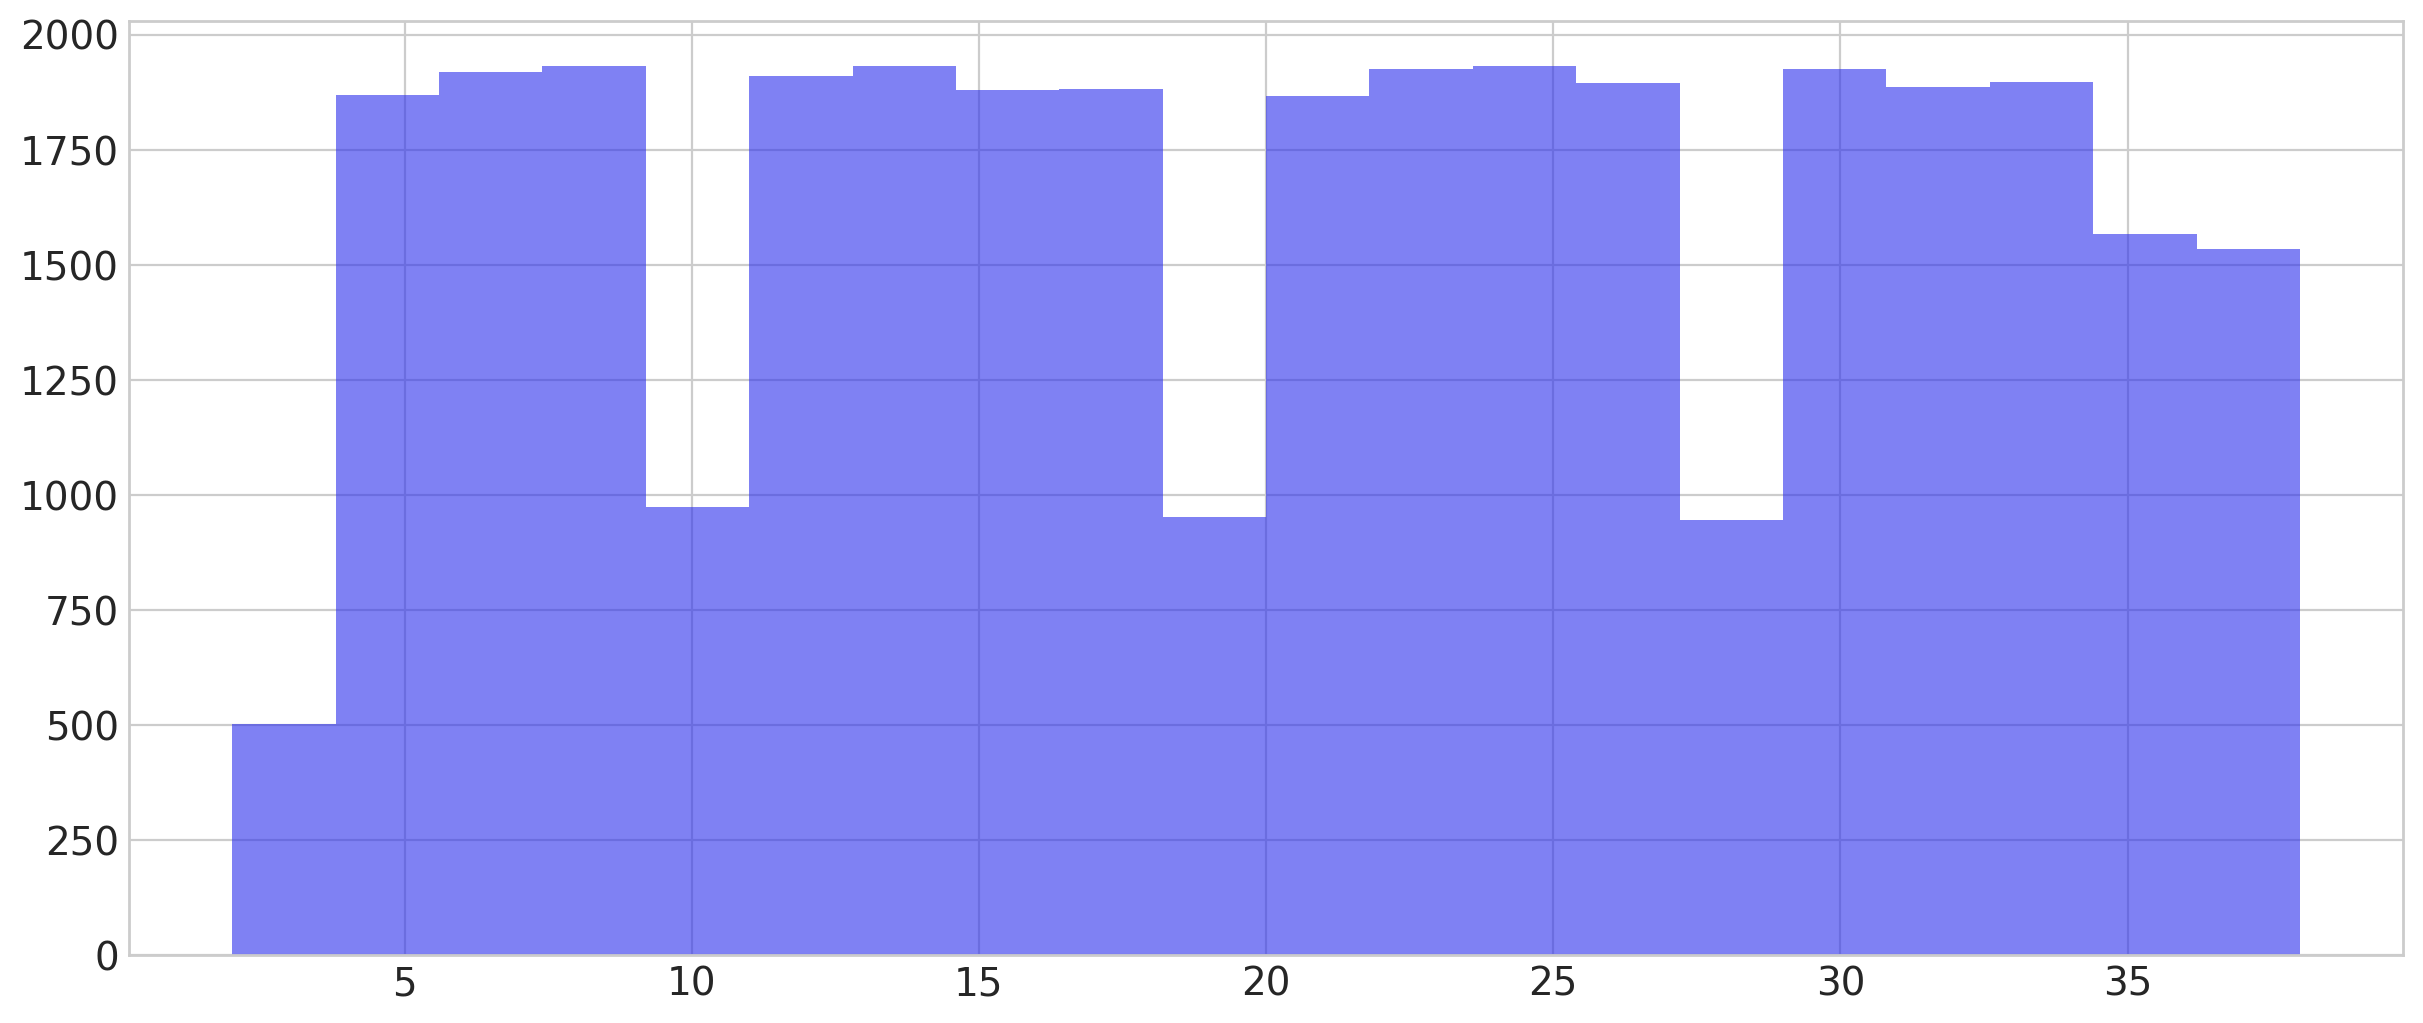

In [10]:
complete_data.gameday.hist(alpha=0.6, bins=20);

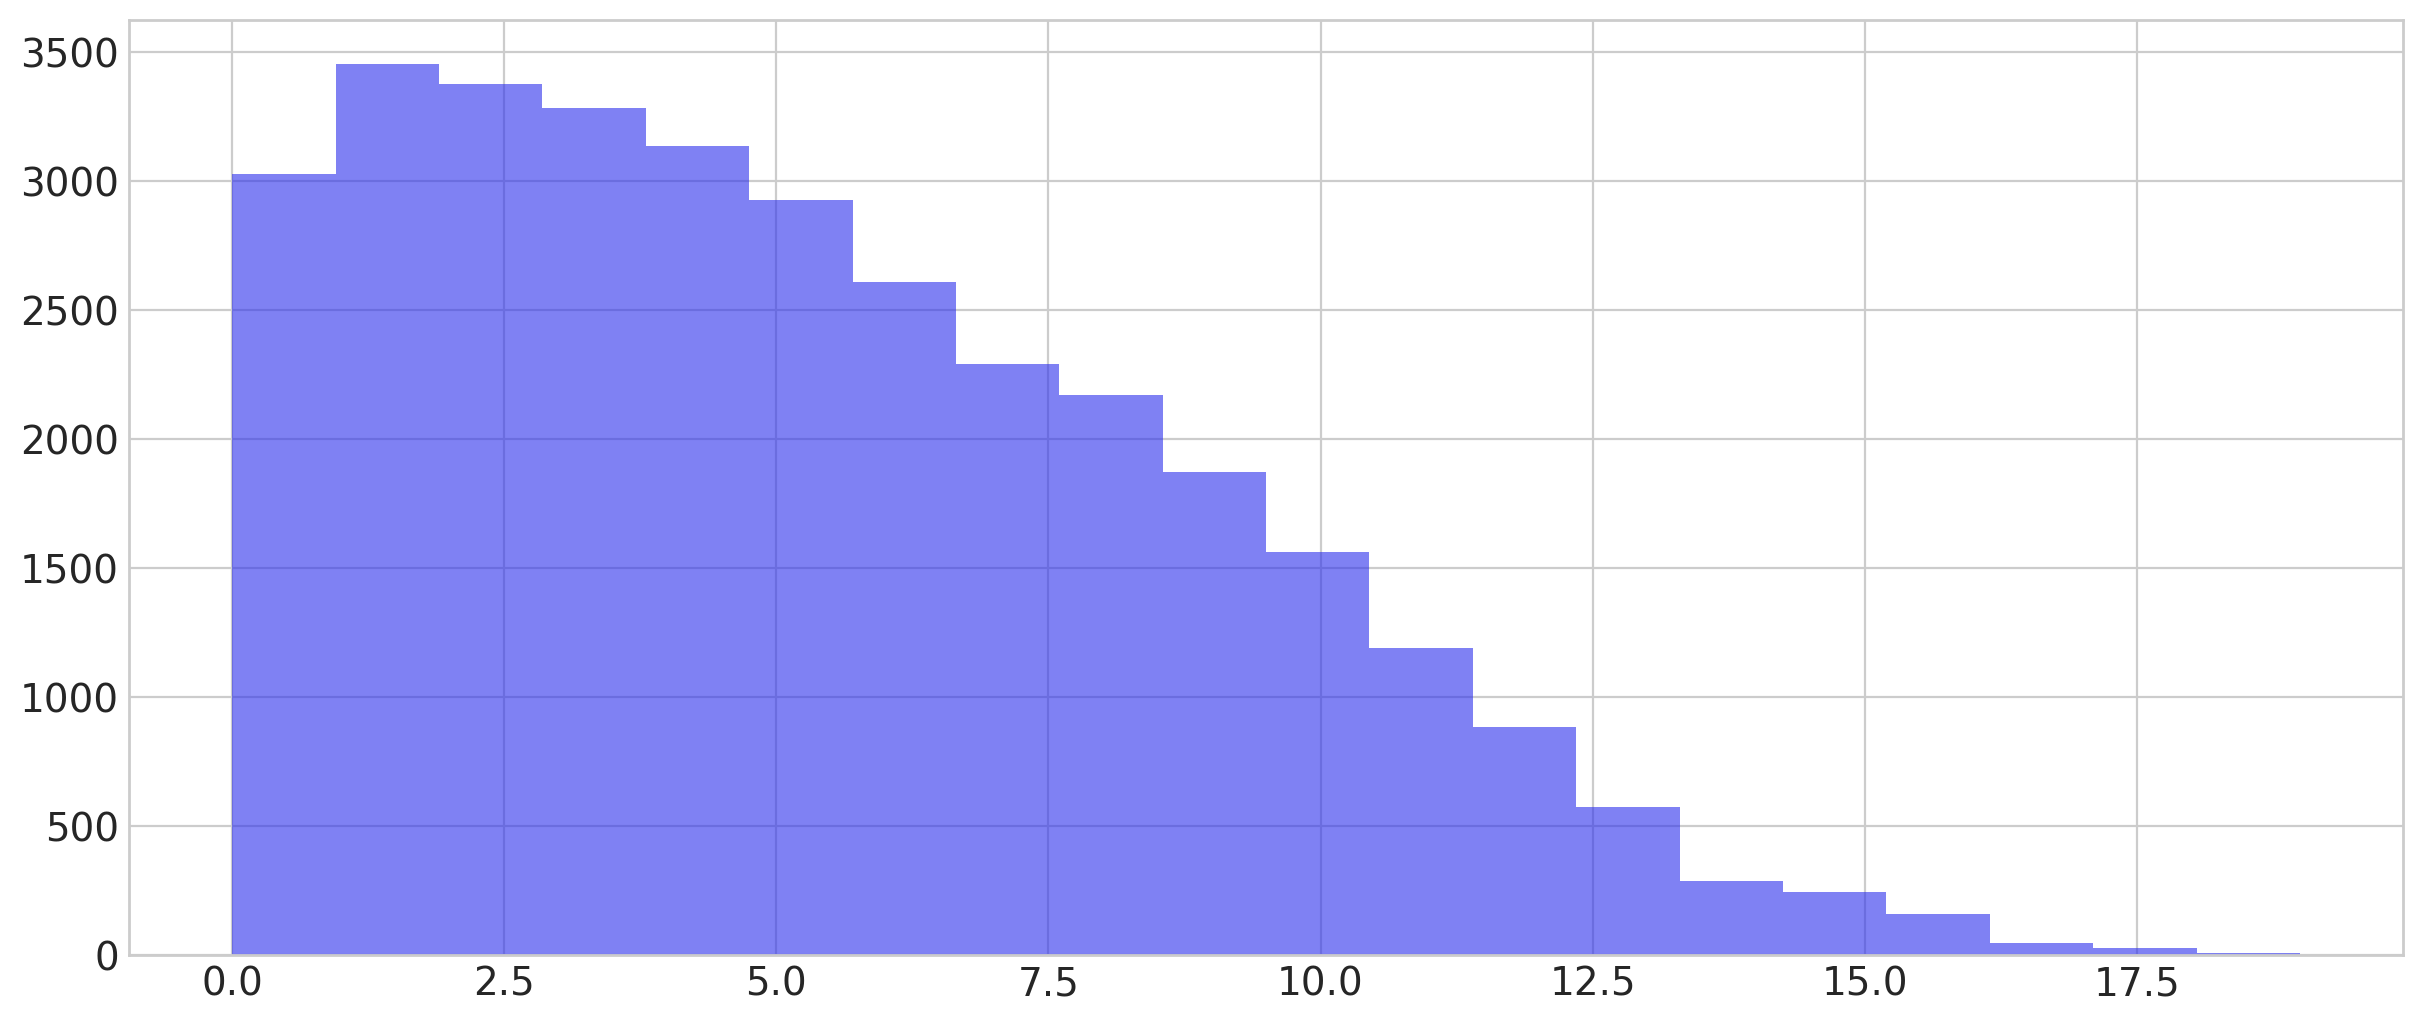

In [11]:
complete_data.season_nbr.hist(alpha=0.6, bins=20);

In [12]:
m_within, c_within = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.gameday.max()],
    lengthscale_range=[5, 25],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m):", m_within)
print("Recommended smallest scaling factor (c):", np.round(c_within, 1))

m_long, c_long = pm.gp.hsgp_approx.approx_hsgp_hyperparams(
    x_range=[0, complete_data.season_nbr.max()],
    lengthscale_range=[2, 6],
    cov_func="matern52",
)

print("Recommended smallest number of basis vectors (m):", m_long)
print("Recommended smallest scaling factor (c):", np.round(c_long, 1))

Recommended smallest number of basis vectors (m): 54
Recommended smallest scaling factor (c): 5.4
Recommended smallest number of basis vectors (m): 32
Recommended smallest scaling factor (c): 2.6


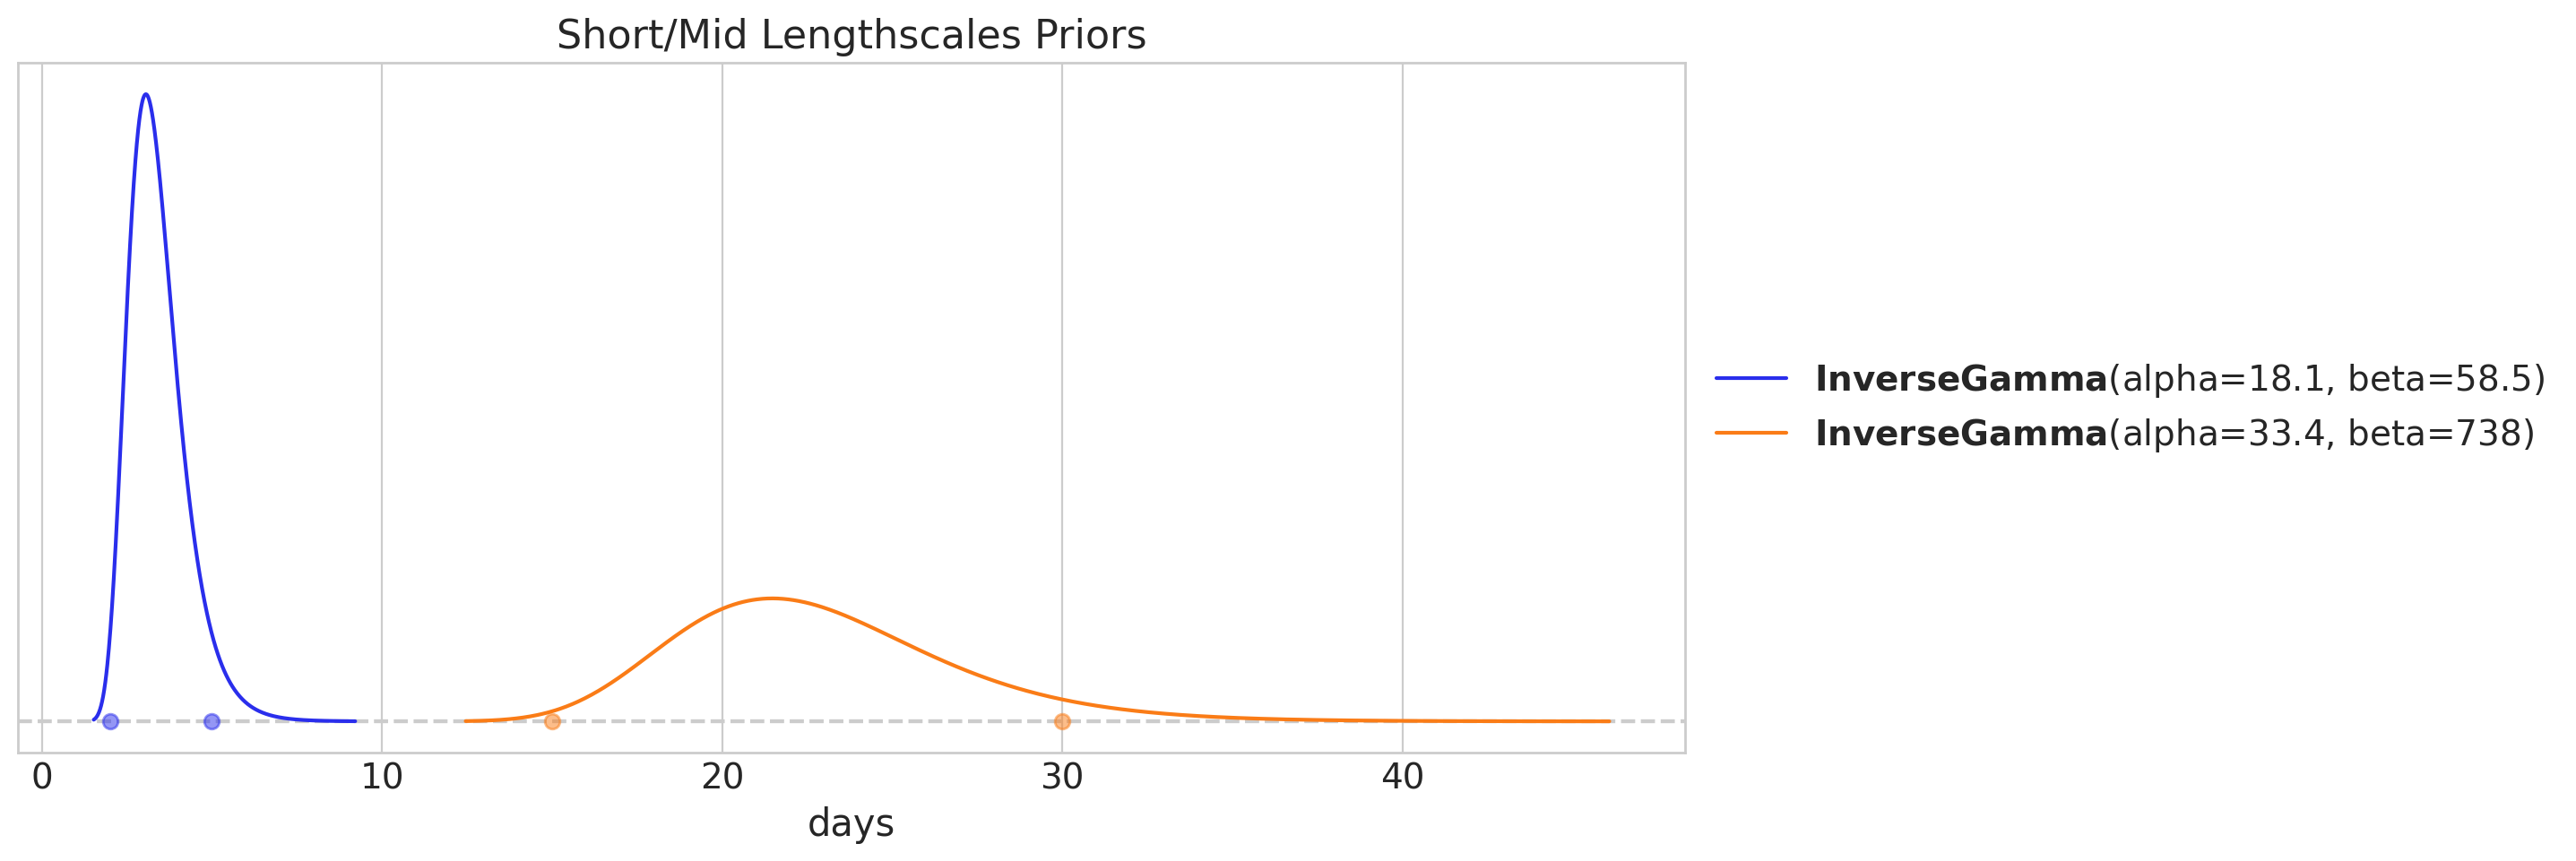

In [13]:
ls_short_dist, _ = pz.maxent(pz.InverseGamma(), 2, 5)
ls_medium_dist, ax = pz.maxent(pz.InverseGamma(), 15, 30)
ax.set(title="Short/Mid Lengthscales Priors", xlabel="days");

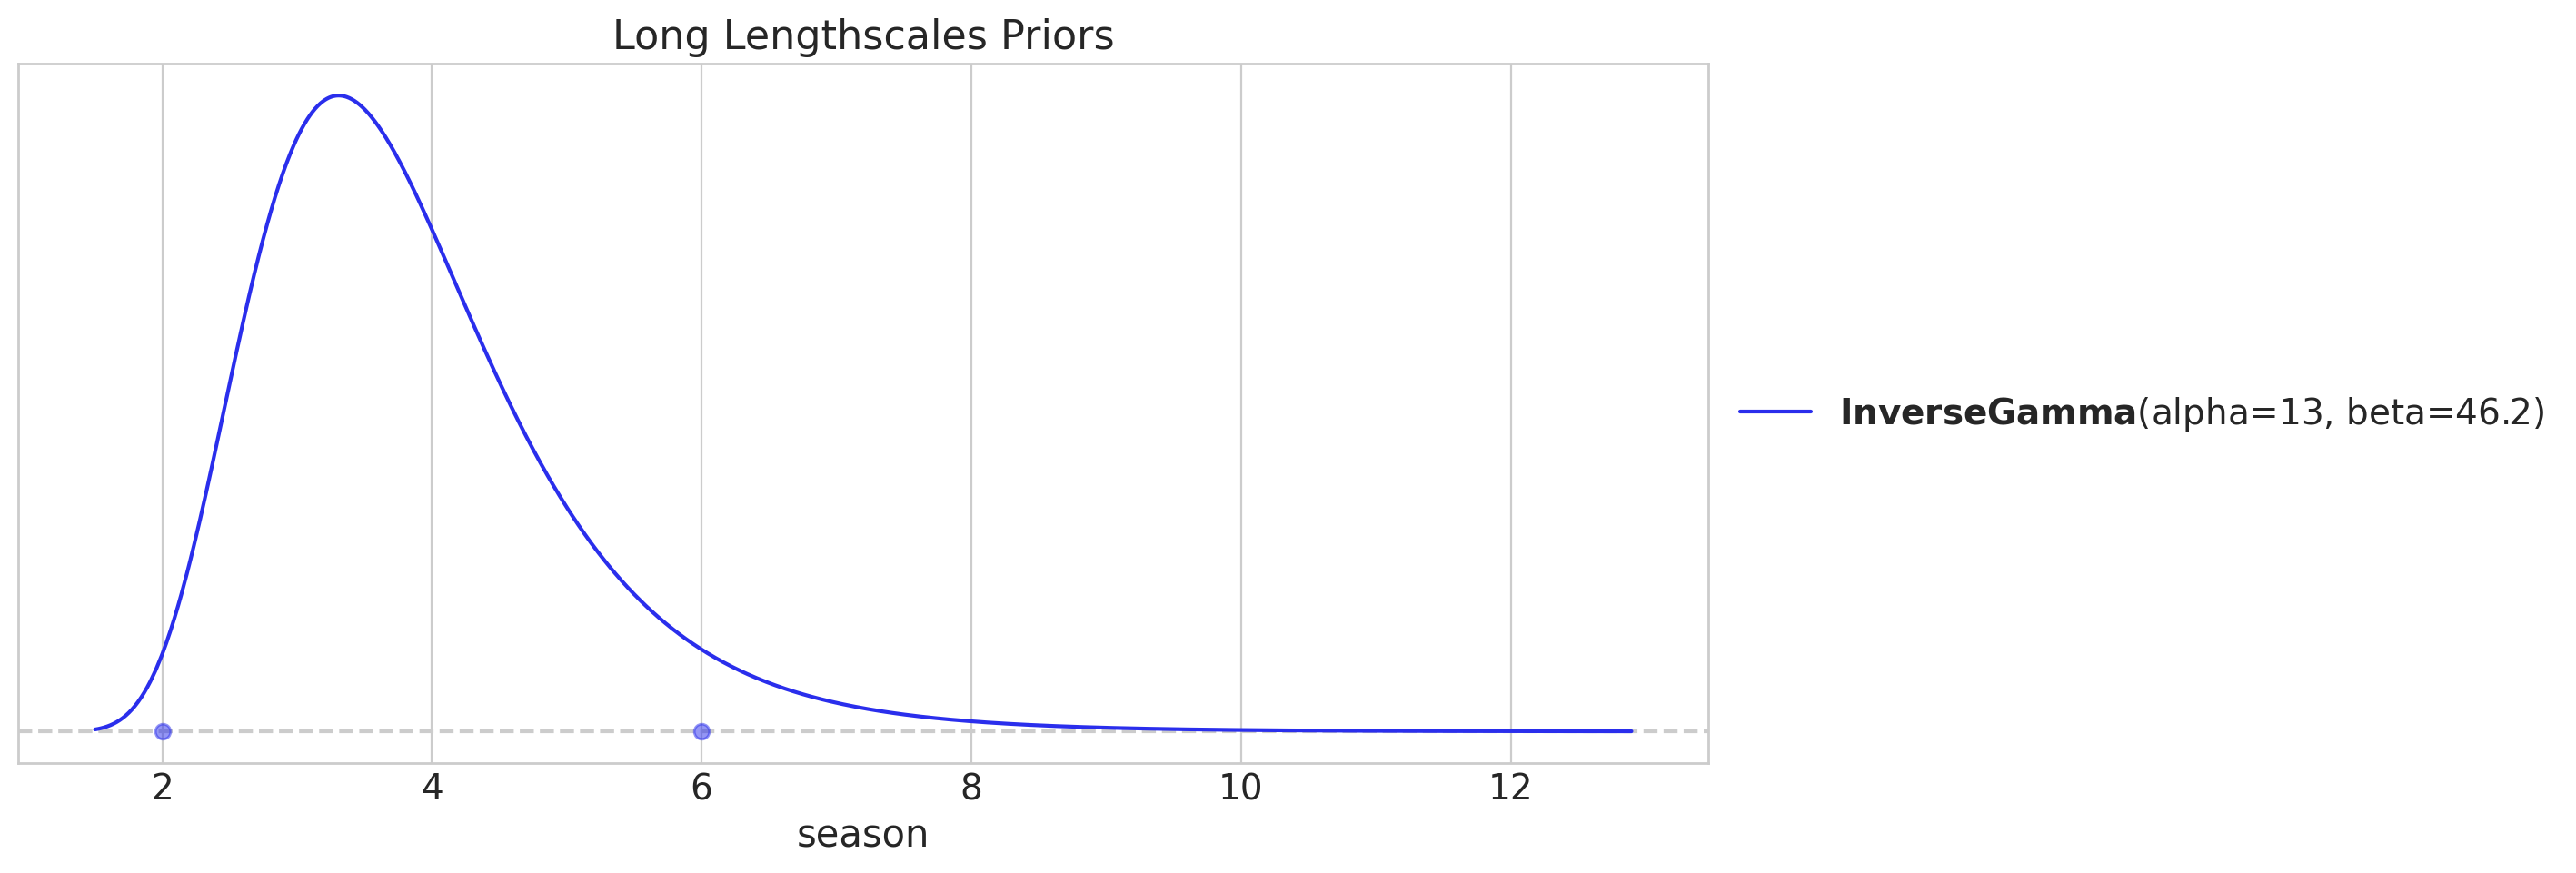

In [14]:
ls_long_dist, ax = pz.maxent(pz.InverseGamma(), 2, 6)
ax.set(title="Long Lengthscales Priors", xlabel="season");

We can now implement our PyMC model. It'll be a big one, but we'll take it step by step.

## PyMC Model

First, let's define some variables we'll use throughout our model building process:

In [15]:
# these don't change between train and test
unique_gamedays = complete_data["gameday"].sort_values().unique()
unique_seasons = complete_data["season_nbr"].sort_values().unique()

# --- Not in use here, still: compute the four goal categories:
complete_data["goals_cats"] = np.where(
    complete_data["goals_in_match"] >= 3, 3, complete_data["goals_in_match"]
)

In [16]:
# these can change
player_idx = pd.Categorical(
    complete_data["name_player"], categories=players_ordered
).codes
gameday_idx = pd.Categorical(
    complete_data["gameday"],
    categories=unique_gamedays,
).codes

COORDS = {
    "event": complete_data["goal"].factorize(sort=True)[1],
    "factor": factors,
    "gameday": unique_gamedays,
    "obs_id": complete_data.index,
    "player": players_ordered,
    "season": unique_seasons,
    "timescale": ["short", "medium", "long"],
}

Then, let's define the data containers for our model:

### Data containers

In [90]:
with pm.Model(coords=COORDS) as SFM:

    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    gameday_id = pm.Data("gameday_id", gameday_idx, dims="obs_id")
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    season_id = pm.Data(
        "season_id", complete_data["season_nbr"].to_numpy(), dims="obs_id"
    )
    #goals_obs = pm.Data(
    #    "goals_obs", complete_data["goals_cats"].to_numpy(), dims="obs_id"
    #)

    # --- Here: 'goals_obs' is now the binary indicator: 0 == player did not score; 1 == player did score
    goals_obs = pm.Data(
        "goals_obs", complete_data['goal'].to_numpy(), dims="obs_id"
    )


    
    

### Players' skills

For the priors we use [those recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).

In [91]:
with SFM:
    intercept_sigma = 5
    sd = pm.Exponential("player_effect_diversity", 1)

    baseline_sigma = pt.sqrt(intercept_sigma**2 + sd**2 / len(COORDS["player"]))
    baseline = baseline_sigma * pm.Normal("baseline")

    player_effect = pm.Deterministic(
        "player_effect",
        baseline + pm.ZeroSumNormal("player_effect_raw", sigma=sd, dims="player"),
        dims="player",
    )

### HSGPs

In [92]:
with SFM:
    X_gamedays = pm.Data("X_gamedays", unique_gamedays, dims="gameday")[:, None]
    X_seasons = pm.Data("X_seasons", unique_seasons, dims="season")[:, None]

    ## 1% chance that amplitude > 2 goals
    alpha_scale, upper_scale = 0.01, 2.0
    amplitude = pm.Exponential(
        "amplitude", lam=-np.log(alpha_scale) / upper_scale, dims="timescale"
    )
    ls = pm.InverseGamma(
        "ls",
        alpha=np.array([ls_short_dist.alpha, ls_medium_dist.alpha, ls_long_dist.alpha]),
        beta=np.array([ls_short_dist.beta, ls_medium_dist.beta, ls_long_dist.beta]),
        dims="timescale",
    )

    # cov matrices
    cov_short = amplitude[0] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[0])
    cov_medium = amplitude[1] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[1])
    cov_within = cov_short + cov_medium
    cov_long = amplitude[2] ** 2 * pm.gp.cov.Matern52(input_dim=1, ls=ls[2])

    ## GPs
    gp_within = pm.gp.HSGP(m=[m_within], c=c_within, cov_func=cov_within)
    basis_vectors_within, sqrt_psd_within = gp_within.prior_linearized(X=X_gamedays)
    basis_coeffs_within = pm.Normal(
        "basis_coeffs_within", shape=gp_within.n_basis_vectors
    )
    f_within = pm.Deterministic(
        "f_within",
        basis_vectors_within @ (basis_coeffs_within * sqrt_psd_within),
        dims="gameday",
    )

    gp_long = pm.gp.HSGP(m=[m_long], c=c_long, cov_func=cov_long)
    basis_vectors_long, sqrt_psd_long = gp_long.prior_linearized(X=X_seasons)
    basis_coeffs_long = pm.Normal("basis_coeffs_long", shape=gp_long.n_basis_vectors)
    f_long = pm.Deterministic(
        "f_long",
        basis_vectors_long @ (basis_coeffs_long * sqrt_psd_long),
        dims="season",
    )

### Regression for player skills

In [93]:
with SFM:
    alpha = pm.Deterministic(
        "alpha",
        player_effect[player_id] + f_within[gameday_id] + f_long[season_id],
        dims="obs_id",
    )

### Adding team factors

> Partially pooled across teams

In [94]:
with SFM:
    #slope = pm.Normal("slope", sigma=2.5, dims="factor")

    #goals_obs_CAT = pd.Categorical(complete_data["goals_cats"]).codes
    
    # --- Here comes BART:
    gX = pmb.BART('gX', factor_data, complete_data['goal'].to_numpy() ,m=100,dims='obs_id')
    

python(85364) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### Likelihood

In [95]:
with SFM:
    
    # --- Regression: add BART as the component modelling team-strength 
    eta = pm.Deterministic(
        "eta", alpha + gX, dims="obs_id"
    )

    
    # --- Probability of Scoring:
    p_score = pm.Deterministic('p_score', pm.math.sigmoid(eta))


    # --- Likelihood:
    y = pm.Bernoulli("y", p_score, observed=goals_obs,dims="obs_id")



## Model graph

python(85372) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


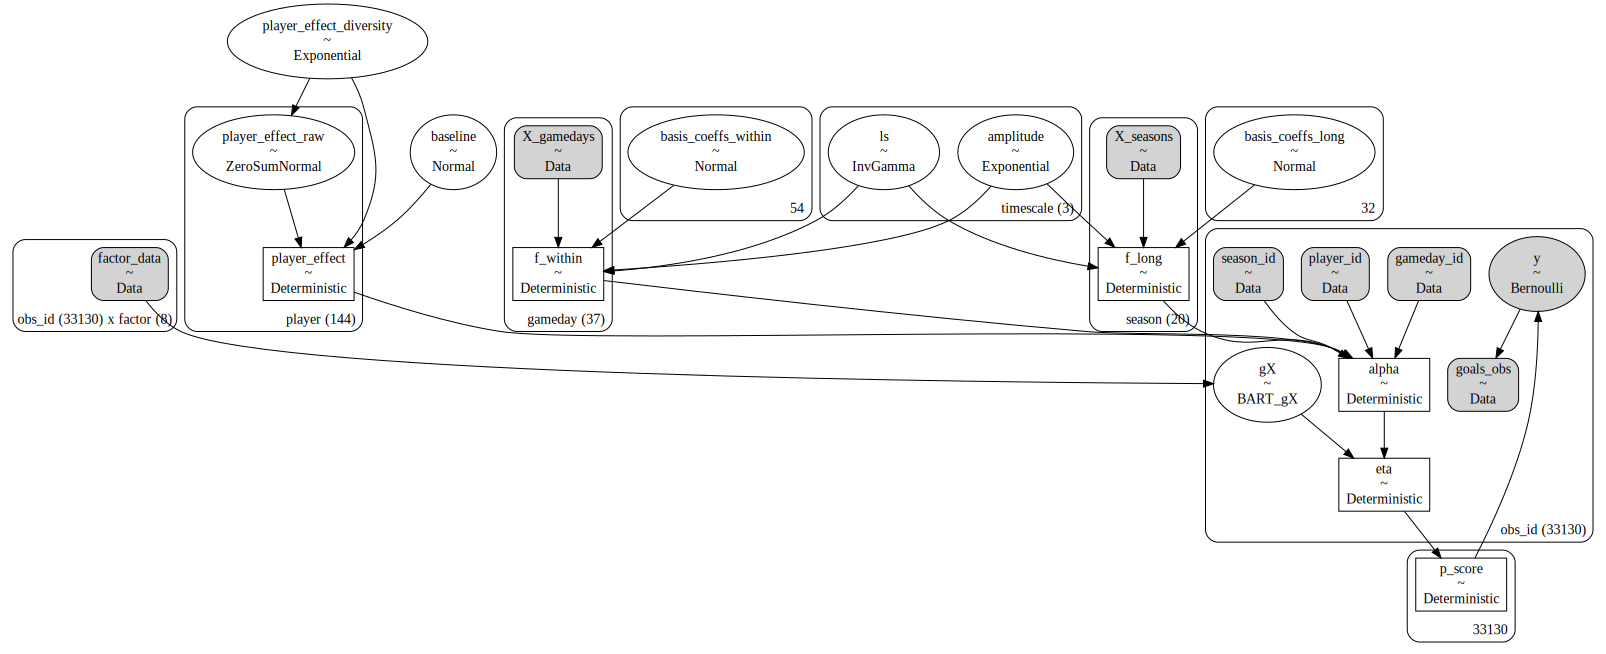

In [96]:
pm.model_to_graphviz(SFM)

## Prior Predictive Sampling

In [97]:
with SFM:
    idata = pm.sample_prior_predictive()

Sampling: [amplitude, baseline, basis_coeffs_long, basis_coeffs_within, gX, ls, player_effect_diversity, player_effect_raw, y]


In [98]:
idata.prior = idata.prior.rename({"p_score_dim_0": "event"})

f_within_prior = idata.prior["f_within"]
f_long_prior = idata.prior["f_long"]

index = pd.MultiIndex.from_product(
    [unique_seasons, unique_gamedays],
    names=["season_nbr", "gameday"],
)
unique_combinations = pd.DataFrame(index=index).reset_index()

f_long_prior_aligned = f_long_prior.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_prior_aligned["timestamp"] = unique_combinations.index

f_within_prior_aligned = f_within_prior.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_prior_aligned["timestamp"] = unique_combinations.index

f_total_prior = f_long_prior_aligned + f_within_prior_aligned

some_draws = rng.choice(f_total_prior.draw, size=20, replace=True)

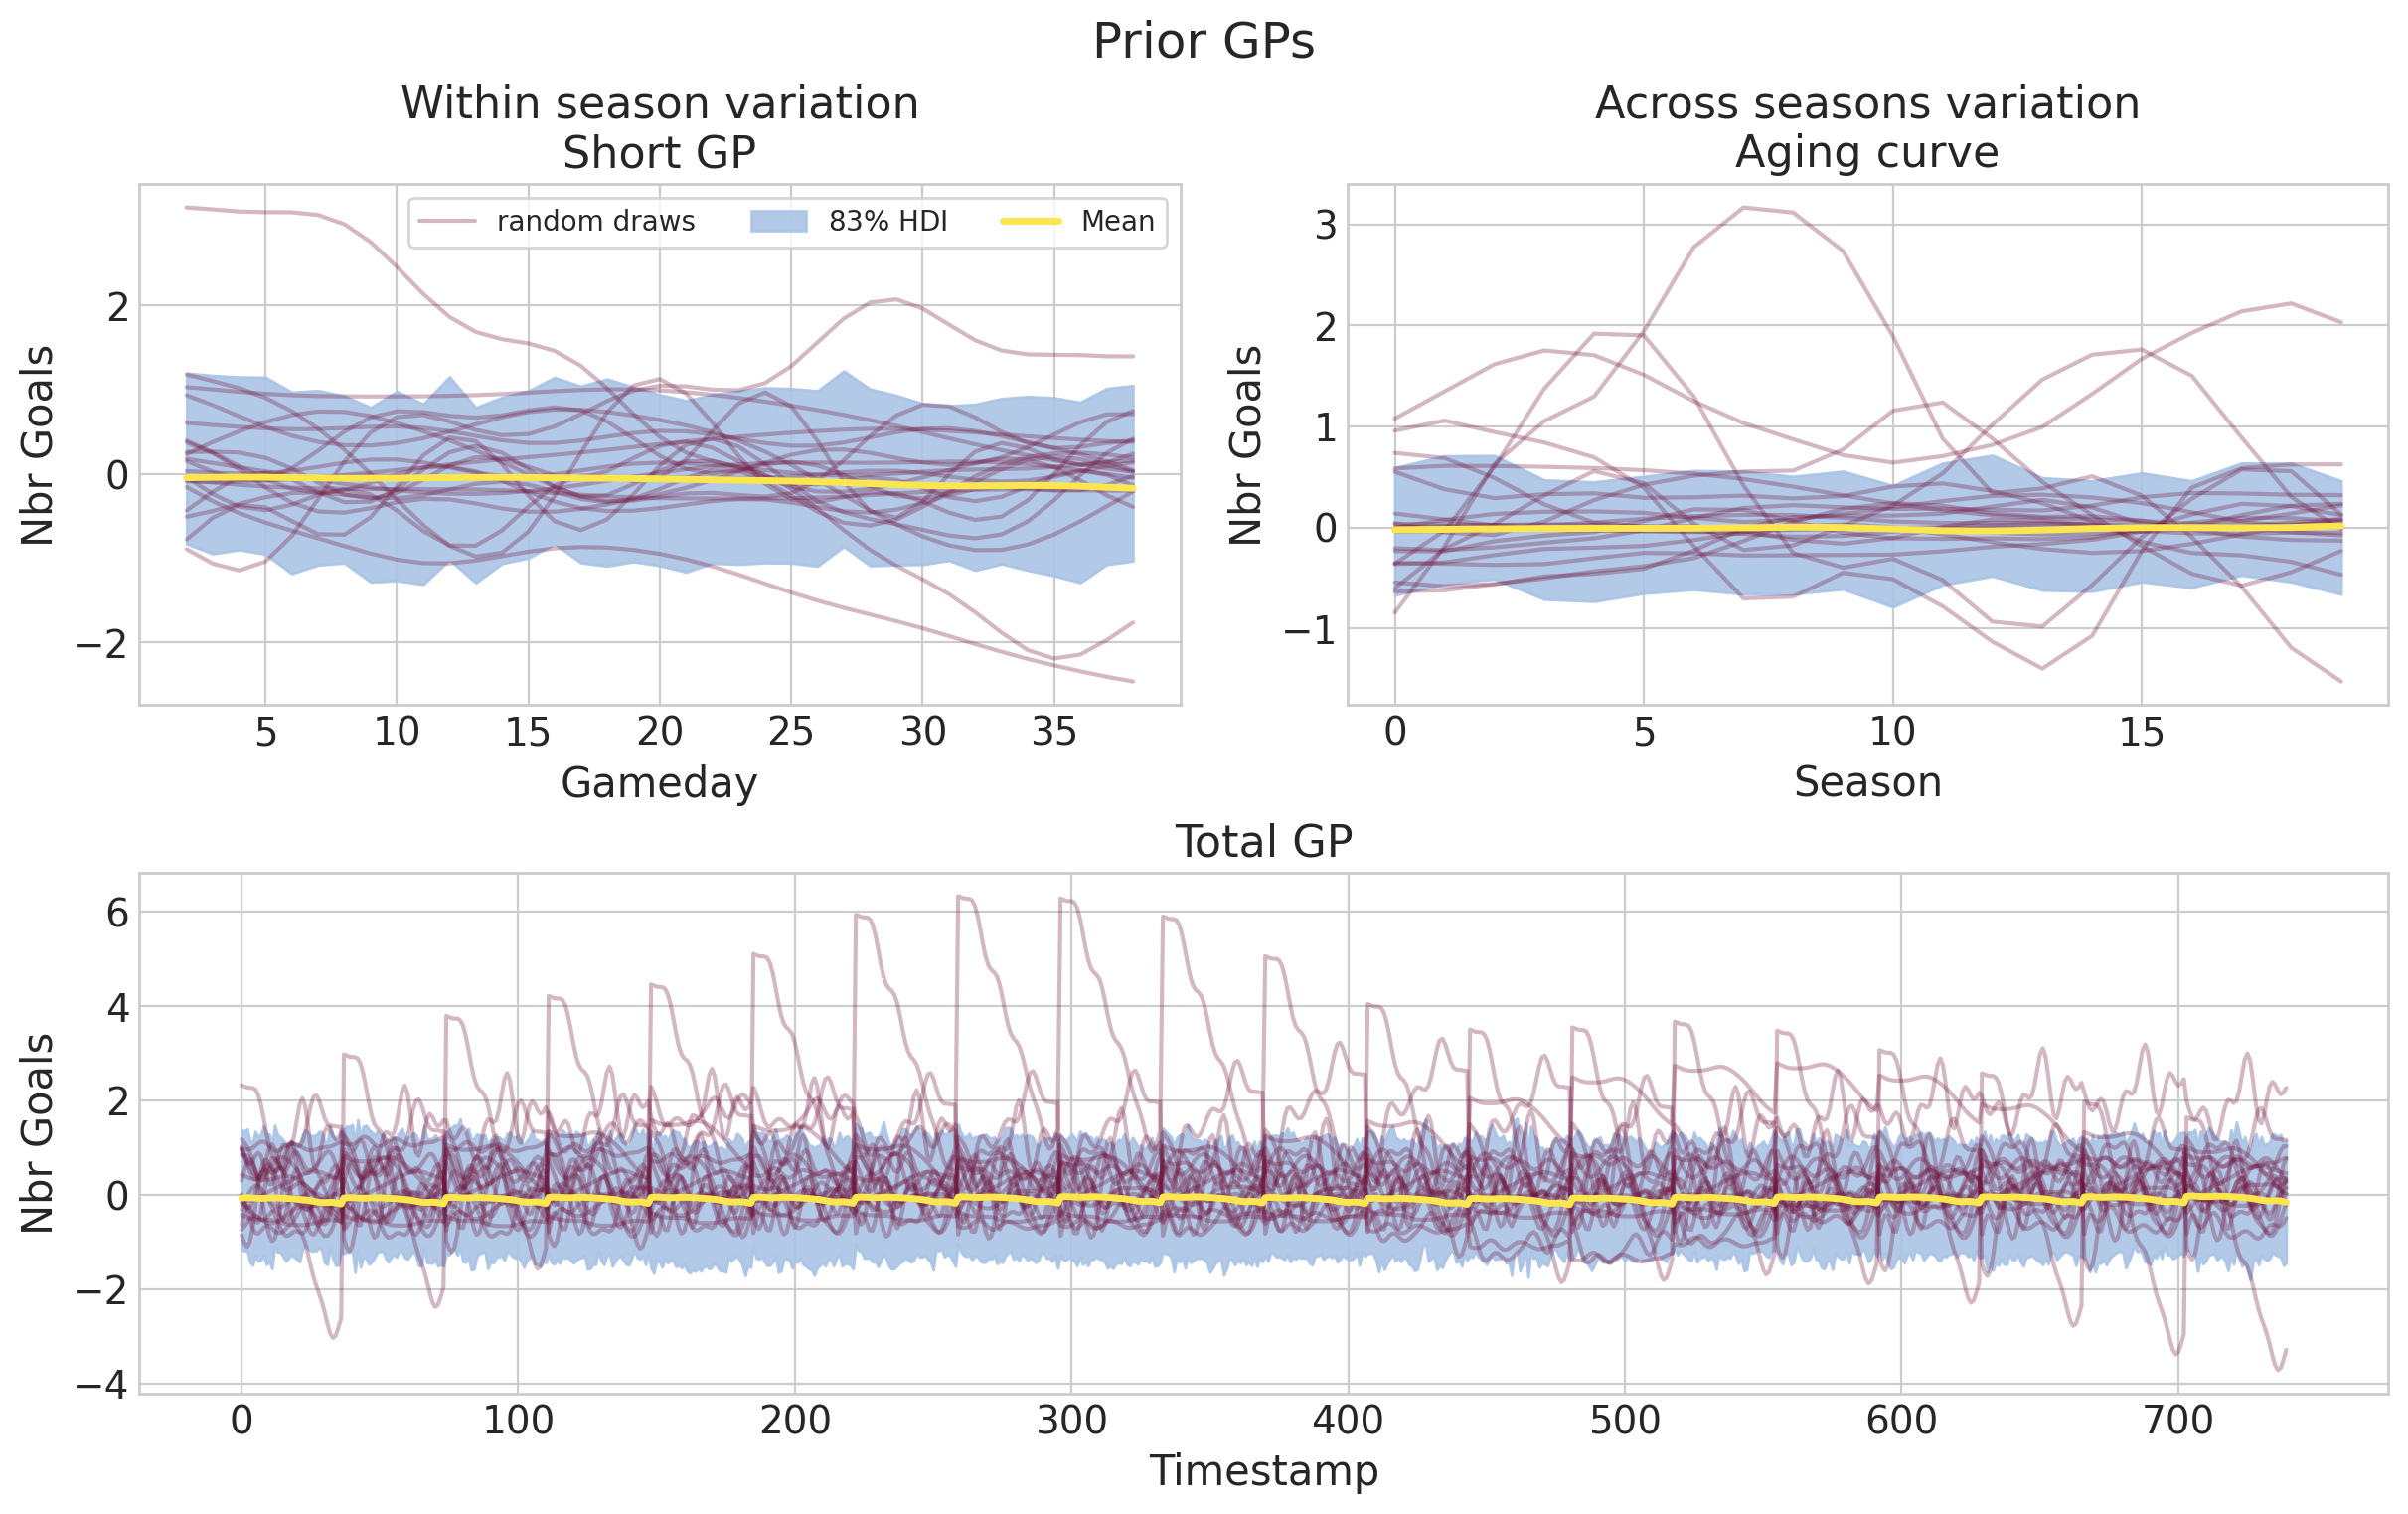

In [99]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
)

axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_prior.gameday,
    az.extract(f_within_prior)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_prior.gameday,
    y=f_within_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_prior.gameday,
    f_within_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_prior.season,
    az.extract(f_long_prior)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_prior.season,
    y=f_long_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_prior.season,
    f_long_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_prior.timestamp,
    az.extract(f_total_prior)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_prior.timestamp,
    y=f_total_prior,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_prior.timestamp,
    f_total_prior.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Prior GPs", fontsize=18);

In [100]:
mindex_coords_original = xr.Coordinates.from_pandas_multiindex(
    complete_data.set_index(["name_player", "season", "gameday"]).index,
    "obs_id",
)

idata.prior = idata.prior.assign_coords(mindex_coords_original)
idata.prior_predictive = idata.prior_predictive.assign_coords(mindex_coords_original)
idata.observed_data = idata.observed_data.assign_coords(mindex_coords_original)

## Sampling and convergence checks

In [101]:
# --- In the paper we use 4 chains
# --- Just for speed: set it to 1
N_chains = 1

with SFM:
    # --- Does not work like this with BART:
    #idata.extend(pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=N_chains))
    # --- When using BART:
    idata.extend(pm.sample(target_accept=0.99, chains=N_chains))

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [player_effect_diversity, baseline, player_effect_raw, amplitude, ls, basis_coeffs_within, basis_coeffs_long]
>PGBART: [gX]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 5934 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [102]:
with SFM:
    idata.extend(pm.sample_posterior_predictive(idata))

Sampling: [y]


Output()

In [103]:
idata.prior = idata.prior.reset_index("obs_id")
idata.prior_predictive = idata.prior_predictive.reset_index("obs_id")
idata.observed_data = idata.observed_data.reset_index("obs_id")

In [ ]:
# --- THIS BLOWS MY STORAGE ... around 7GB
#az.to_netcdf(idata, "idata_complete.nc")

In [ ]:
if 1==2:
    idata.sample_stats.acceptance_rate.mean().data.round(2)

In [ ]:
if 1==2:
    idata.sample_stats.diverging.sum().data

In [ ]:
#az.ess(idata).min().to_pandas().sort_values().round()

In [ ]:
if 1==2:
    az.summary(
        idata,
        var_names=[
            "amplitude",
            "baseline",
            "player_effect_diversity",
            "ls",
            "slope",
            "delta_sigma",
            "delta_mean",
        ],
        round_to=2,
    )

In [ ]:
if 1==2:
    az.ess(
        idata,
        var_names=["basis_coeffs_long", "basis_coeffs_within"],
    ).min().to_pandas().round(2)

In [ ]:
if 1==2:
    az.rhat(
        idata,
        var_names=["basis_coeffs_long", "basis_coeffs_within"],
    ).max().to_pandas().round(2)

In [ ]:
if 1==2:
    az.plot_trace(
        idata,
        var_names=["~alpha", "~goals_scored_probs", "~eta", "~_raw", "~hsgp_coeffs"],
        filter_vars="regex",
    );

## Variable Importance

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  func(*args, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or Axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


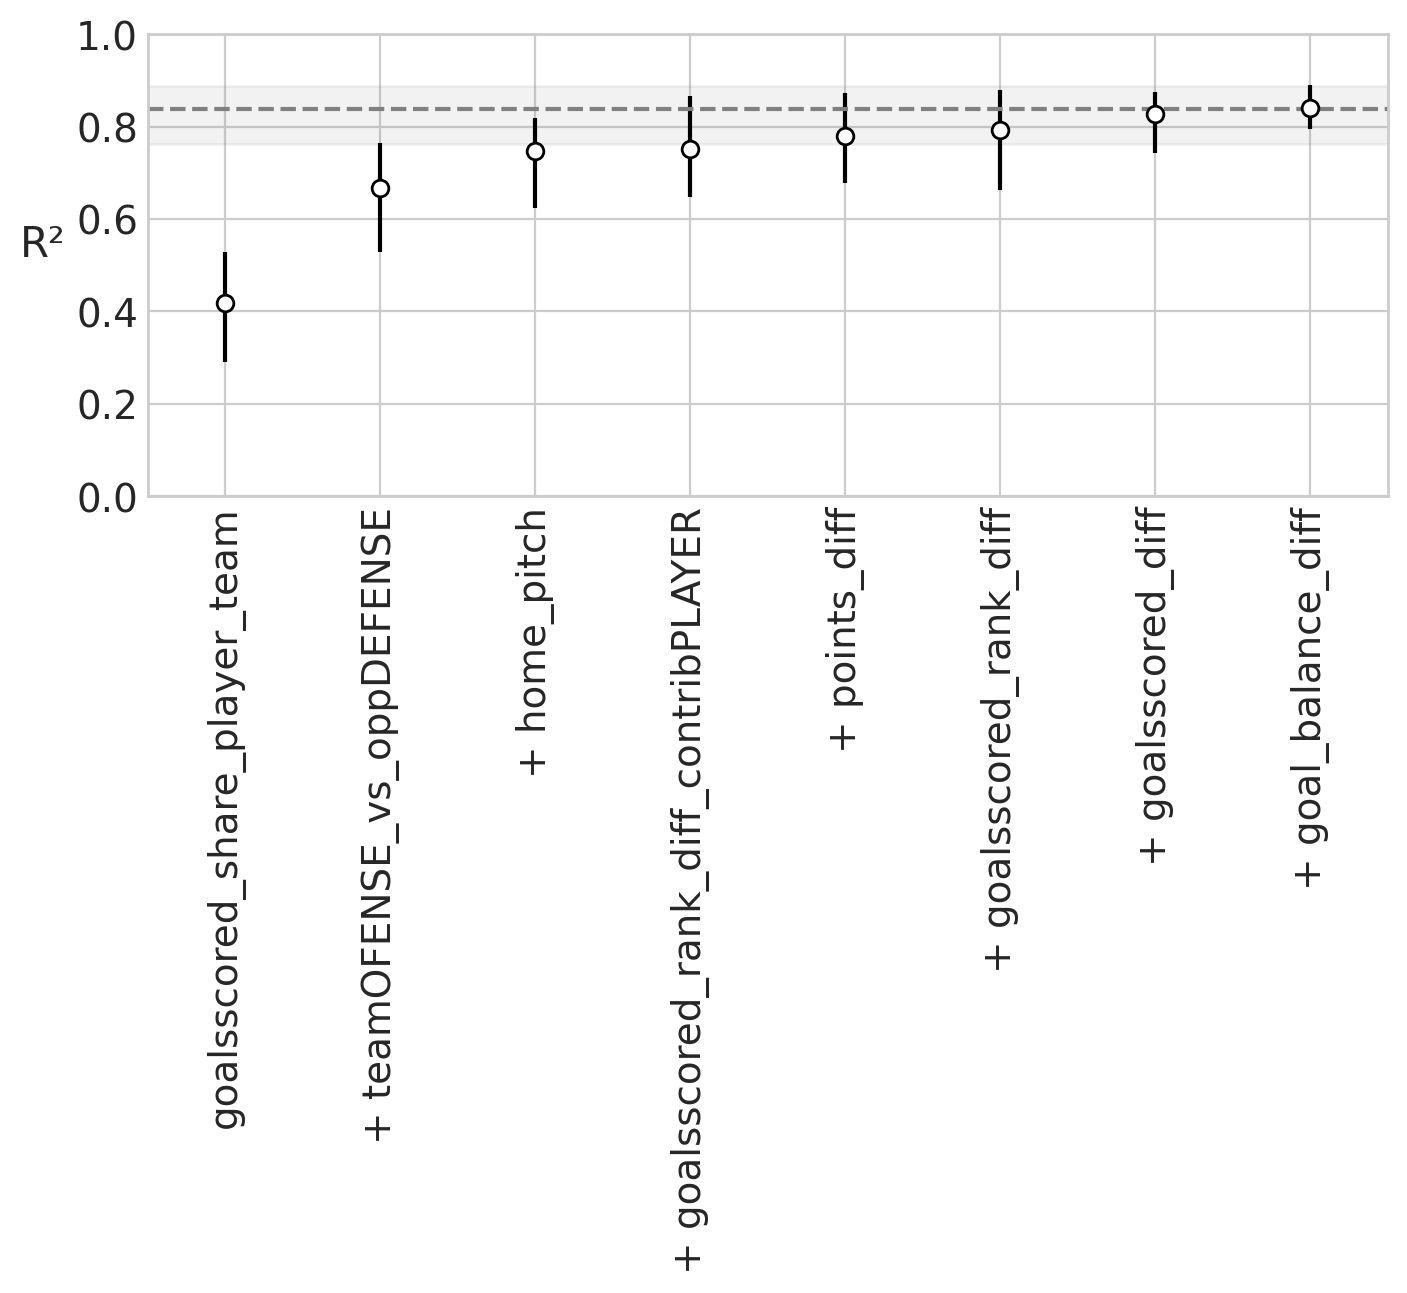

In [119]:
# -------------------- Variable Importance -------------------- #
df_X = pd.DataFrame(factors_sdz.to_numpy(), columns=factors)
pmb.plot_variable_importance(idata, gX, df_X, method="VI", random_seed=123, plot_kwargs={'rotation':90});


## Posterior parameters

In [ ]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 3),
        layout="constrained",
    )
    
    az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names=["slope"],
        combined=True,
        ax=axes["A"],
    )
    axes["A"].axvline(c="grey", ls="--")
    axes["A"].set(title="Slopes")
    
    az.plot_forest(
        idata,
        var_names=["slope"],
        combined=True,
        ax=axes["B"],
    )
    axes["B"].axvline(c="grey", ls="--")
    axes["B"].set(title="Posterior only");

In [ ]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 4),
        layout="constrained",
    )
    
    az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names=["diversity", "amplitude", "sd_", "_sigma"],
        combined=True,
        filter_vars="regex",
        ax=axes["A"],
    )
    axes["A"].set(title="Standard deviations")
    
    az.plot_forest(
        idata,
        var_names=["diversity", "amplitude", "sd_", "_sigma"],
        combined=True,
        filter_vars="regex",
        ax=axes["B"],
    )
    axes["B"].set(title="Posterior only");

In [ ]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 35),
        layout="constrained",
    )
    
    az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names="player_effect",
        combined=True,
        ax=axes["A"],
    )
    axes["A"].axvline(x=idata.posterior.player_effect.mean(), c="grey", ls="--")
    axes["A"].set(title="Player effects")
    
    az.plot_forest(
        idata,
        var_names="player_effect",
        combined=True,
        ax=axes["B"],
    )
    axes["B"].axvline(x=idata.posterior.player_effect.mean(), c="grey", ls="--")
    axes["B"].set(title="Posterior only");

In [ ]:
if 1==2:
    ax = az.plot_forest(
        [idata.prior, idata.posterior],
        model_names=["Prior", "Posterior"],
        var_names="ls",
        combined=True,
        figsize=(10, 3),
    )
    ax[0].set(title="GPs lengthscales");

In [ ]:
if 1==2:
    _, axes = plt.subplot_mosaic(
        """
        AB
        """,
        figsize=(12, 70),
        layout="constrained",
    )
    az.plot_forest(
        [idata.prior["cutpoints"], idata.posterior["cutpoints"]],
        combined=True,
        model_names=["Prior", "Posterior"],
        ax=axes["A"],
    )
    axes["A"].set(title="Cutpoints")
    az.plot_forest(
        idata,
        var_names=["cutpoints"],
        combined=True,
        ax=axes["B"],
    )
    axes["B"].set(title="Posterior only");

In [ ]:
if 1==2:
    az.plot_forest(
        [idata.prior["eta"], idata.posterior["eta"]],
        combine_dims={"chain", "draw", "obs_id"},
        combined=True,
        model_names=["Prior", "Posterior"],
        figsize=(10, 3),
    );

## Performance evolution through time

In [104]:
f_long_post = idata.posterior["f_long"]
f_within_post = idata.posterior["f_within"]

f_long_post_aligned = f_long_post.sel(
    season=unique_combinations["season_nbr"].to_numpy()
).rename({"season": "timestamp"})
f_long_post_aligned["timestamp"] = unique_combinations.index

f_within_post_aligned = f_within_post.sel(
    gameday=unique_combinations["gameday"].to_numpy()
).rename({"gameday": "timestamp"})
f_within_post_aligned["timestamp"] = unique_combinations.index

f_total_post = f_long_post_aligned + f_within_post_aligned

some_draws = rng.choice(int(N_chains*1000), size=20, replace=True)

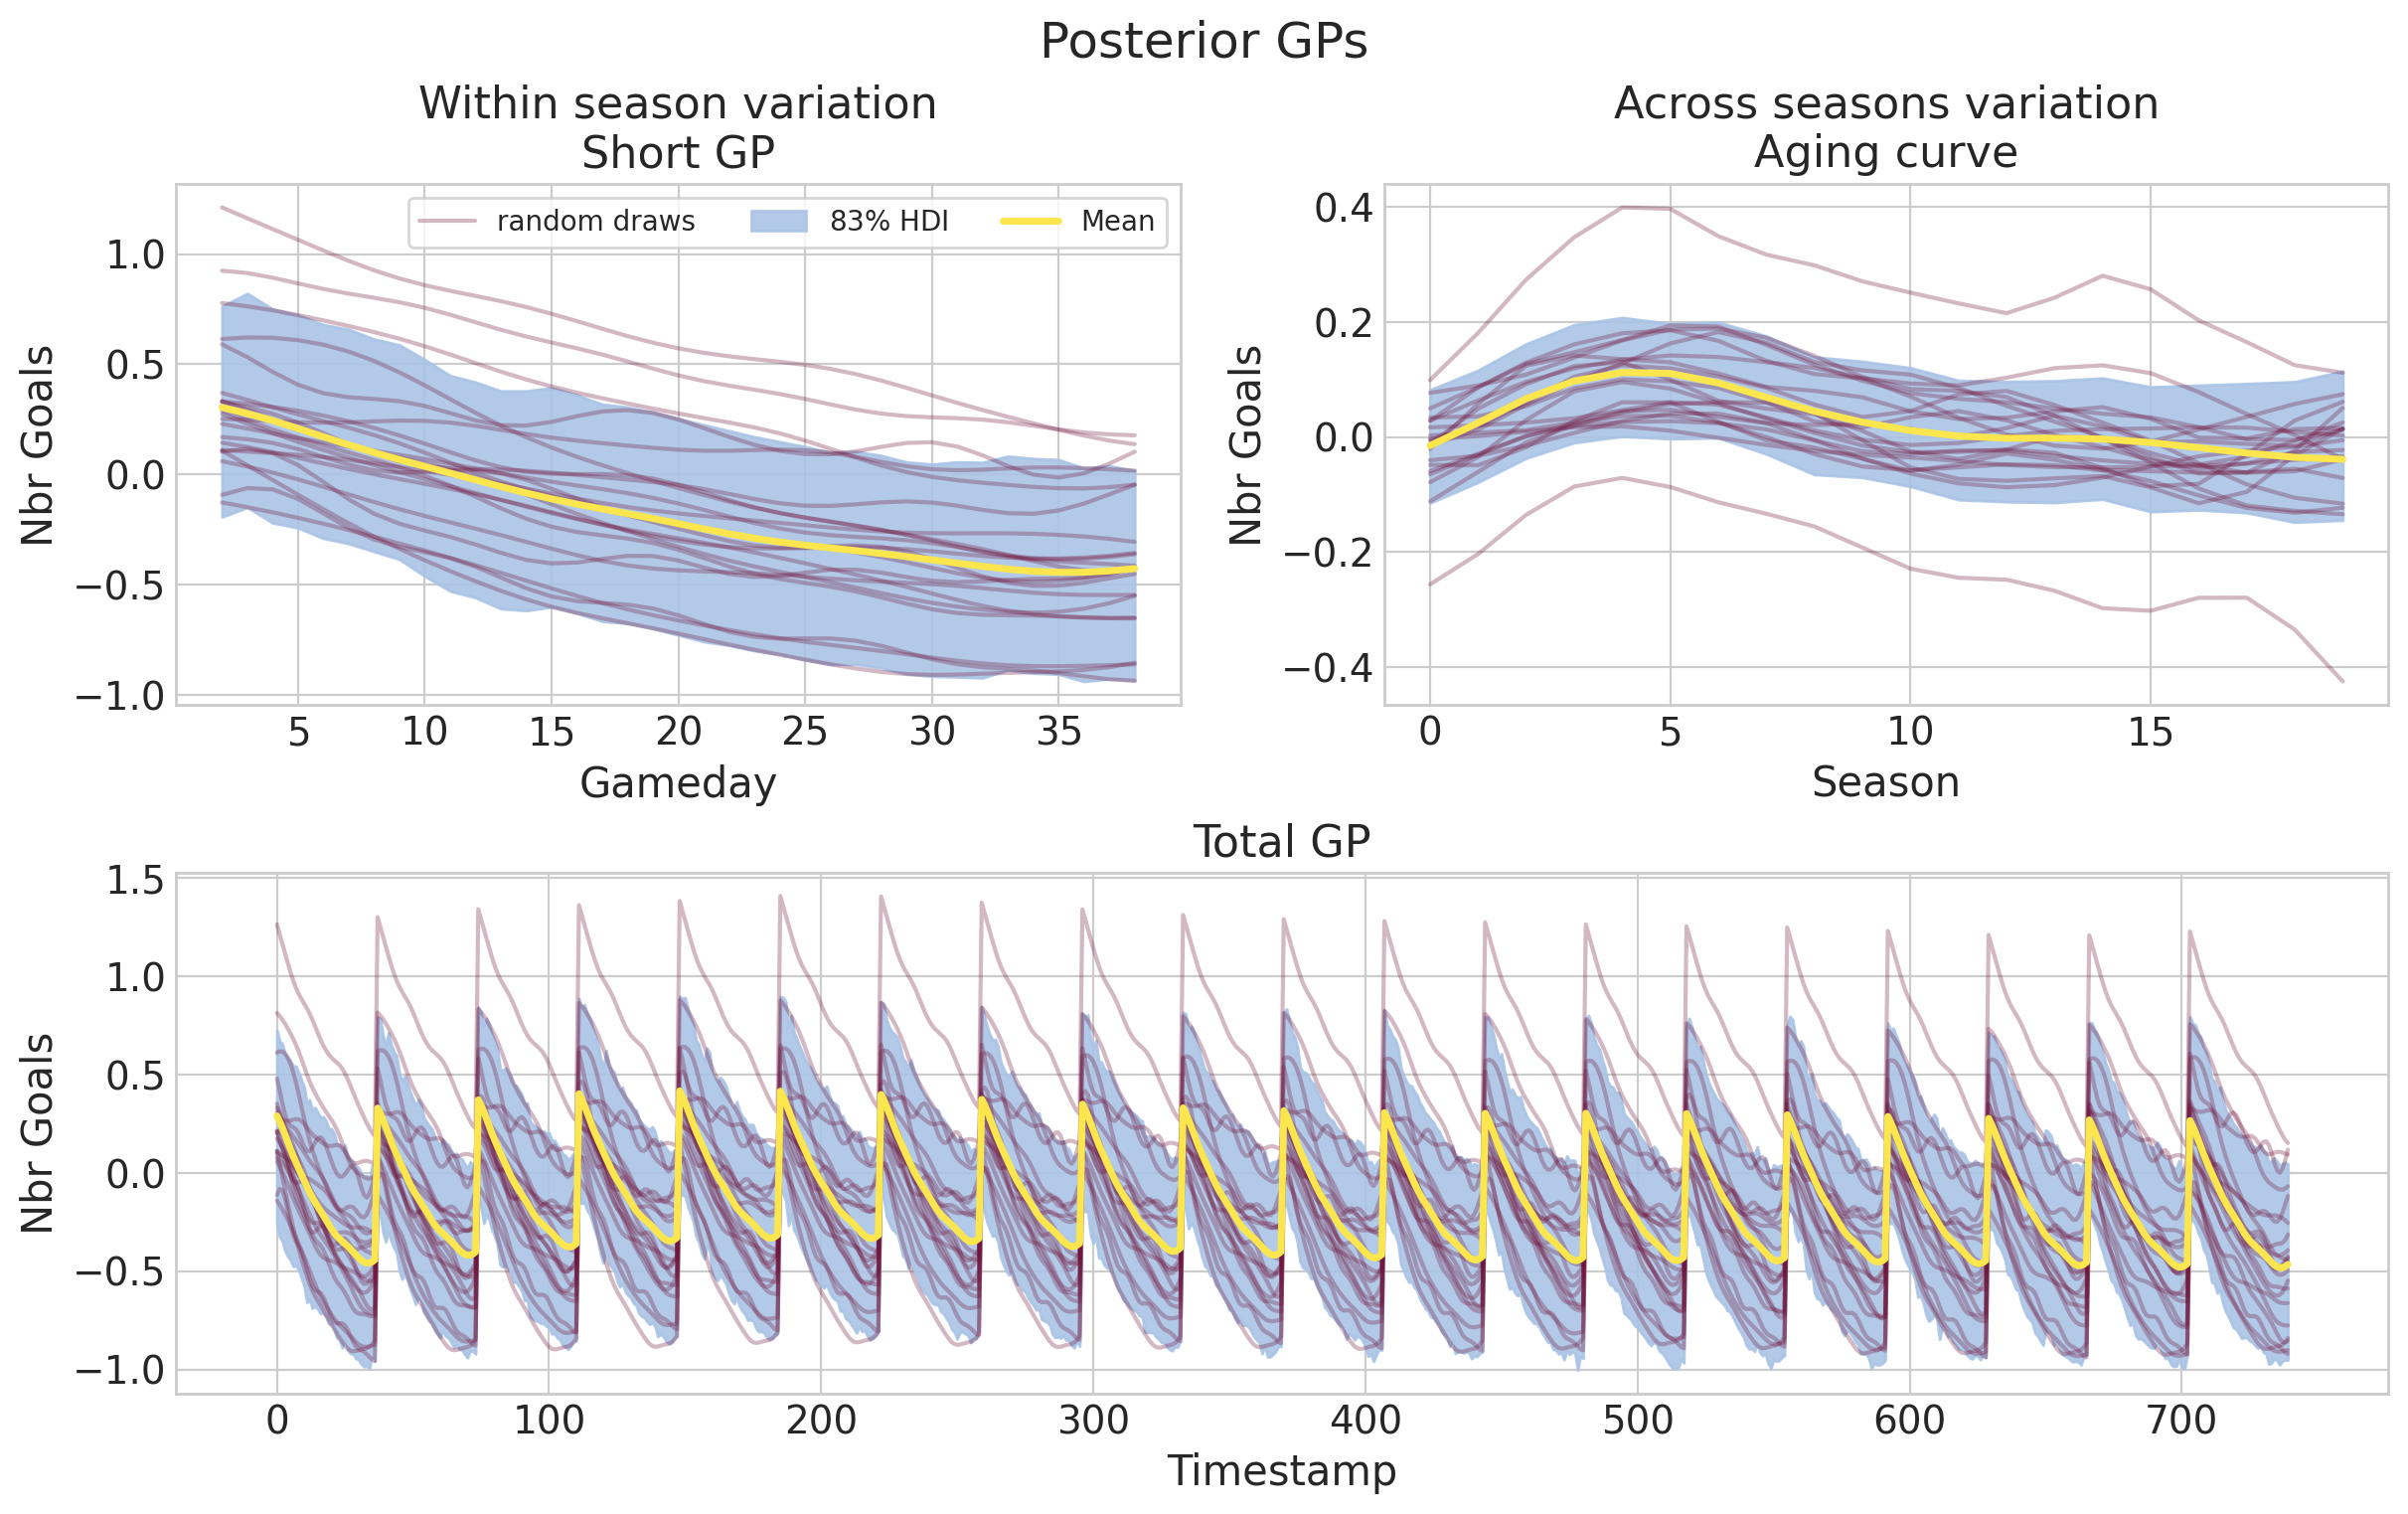

In [105]:
_, axes = plt.subplot_mosaic(
    """
    AB
    CC
    """,
    figsize=(12, 7.5),
    layout="constrained",
)

axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_post.gameday,
    y=f_within_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_post.gameday,
    f_within_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title="Within season variation\nShort GP"
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3)

axes["B"].plot(
    f_long_post.season,
    az.extract(f_long_post)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_post.season,
    y=f_long_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_post.season,
    f_long_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title="Across seasons variation\nAging curve"
)

axes["C"].plot(
    f_total_post.timestamp,
    az.extract(f_total_post)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_post.timestamp,
    y=f_total_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_post.timestamp,
    f_total_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="Total GP")
plt.suptitle("Posterior GPs", fontsize=18);

[Text(0.5, 0, 'Timestamp'), Text(0, 0.5, 'Nbr Goals'), Text(0.5, 1.0, '')]

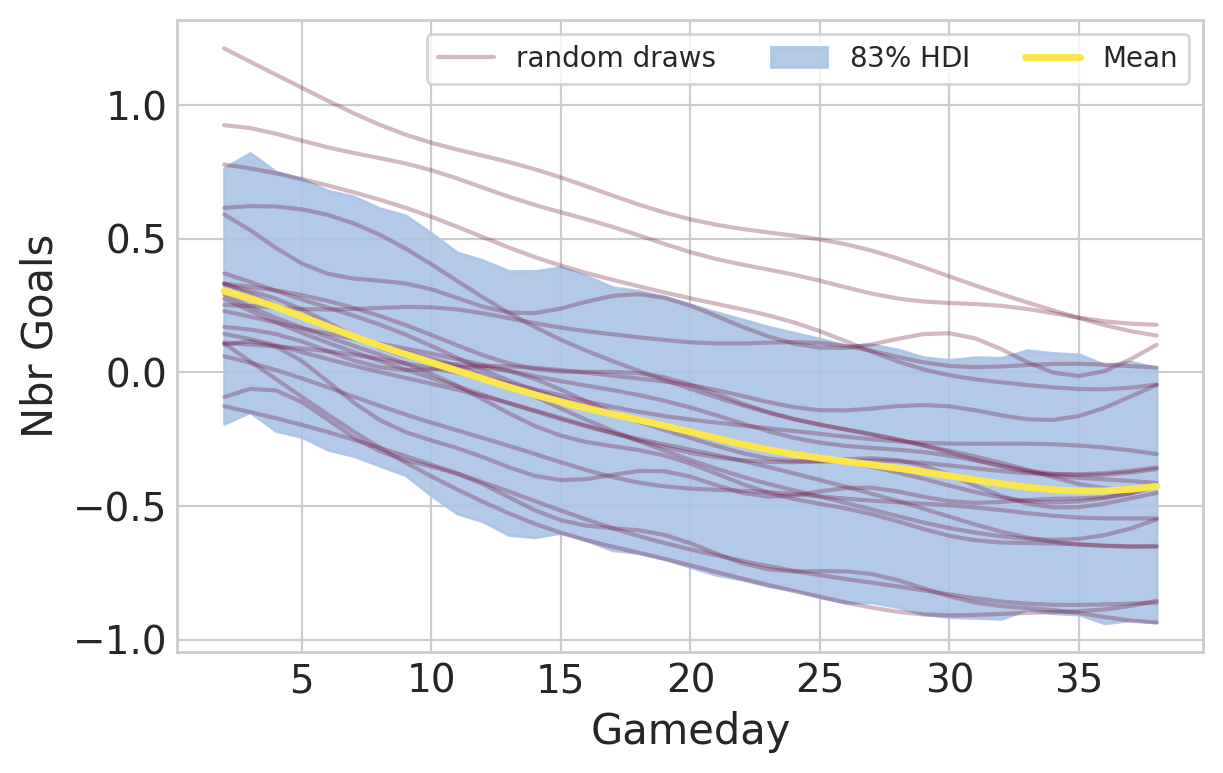

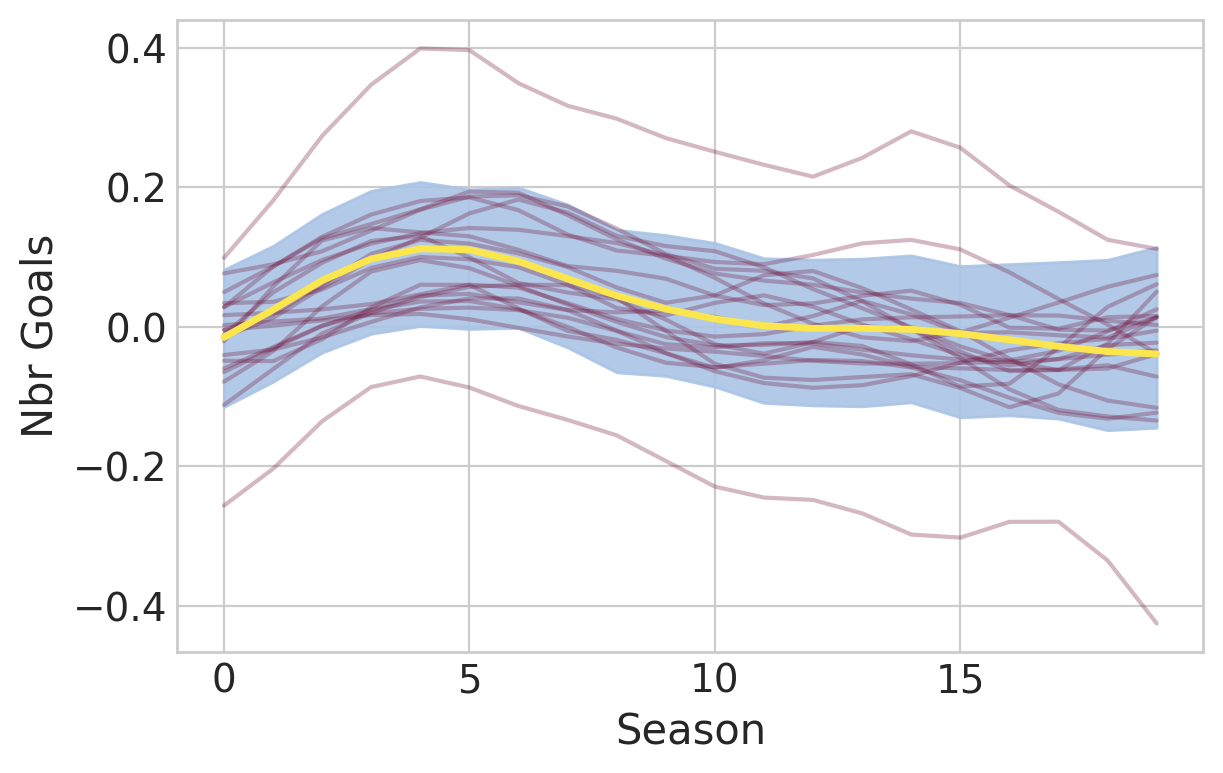

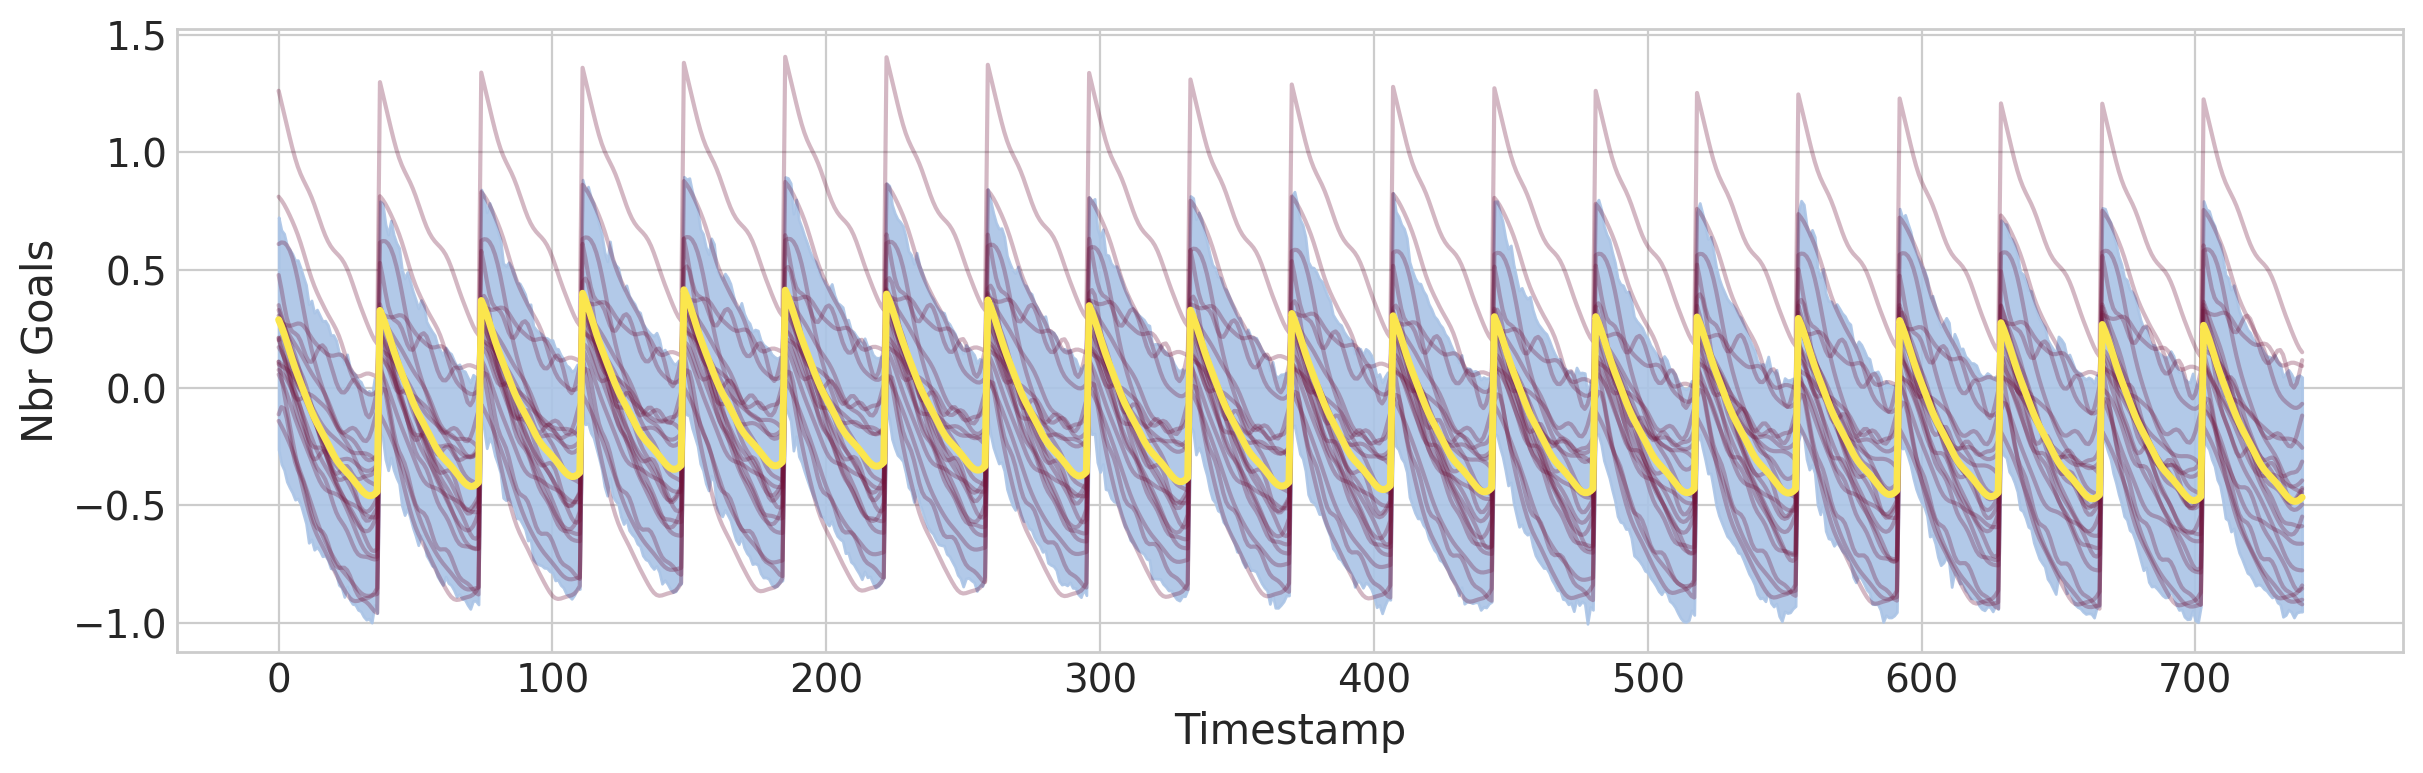

In [106]:
figA, axes = plt.subplot_mosaic(
    """
    A
    """,
    figsize=(6, 3.75),
    layout="constrained",
)

axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=0),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
    label="random draws",
)
axes["A"].plot(
    f_within_post.gameday,
    az.extract(f_within_post)["f_within"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_within_post.gameday,
    y=f_within_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9, "label": r"$83\%$ HDI"},
    ax=axes["A"],
    smooth=False,
)
axes["A"].plot(
    f_within_post.gameday,
    f_within_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
    label="Mean",
)
axes["A"].set(
    xlabel="Gameday", ylabel="Nbr Goals", title=""
)
axes["A"].legend(fontsize=10, frameon=True, ncols=3, loc='upper right')



figB, axes = plt.subplot_mosaic(
    """
    B
    """,
    figsize=(6, 3.75),
    layout="constrained",
)

axes["B"].plot(
    f_long_post.season,
    az.extract(f_long_post)["f_long"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_long_post.season,
    y=f_long_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["B"],
    smooth=False,
)
axes["B"].plot(
    f_long_post.season,
    f_long_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["B"].set(
    xlabel="Season", ylabel="Nbr Goals", title=""
)


figC, axes = plt.subplot_mosaic(
    """
    C
    """,
    figsize=(12, 3.75),
    layout="constrained",
)

axes["C"].plot(
    f_total_post.timestamp,
    az.extract(f_total_post)["x"].isel(sample=some_draws),
    color="#70133A",
    alpha=0.3,
    lw=1.5,
)
az.plot_hdi(
    x=f_total_post.timestamp,
    y=f_total_post,
    hdi_prob=0.83,
    color="#AAC4E6",
    fill_kwargs={"alpha": 0.9},
    ax=axes["C"],
    smooth=False,
)
axes["C"].plot(
    f_total_post.timestamp,
    f_total_post.mean(("chain", "draw")),
    color="#FBE64D",
    lw=2.5,
)
axes["C"].set(xlabel="Timestamp", ylabel="Nbr Goals", title="")
#plt.suptitle("Posterior GPs", fontsize=18);

In [ ]:
if 1==2:
    figA.savefig('../20_figures/HSGPs_within.png')
    figB.savefig('../20_figures/HSGPs_across.png')
    figC.savefig('../20_figures/HSGPs_total.png')

## PAR Analysis

### From posterior samples

In [107]:
with SFM:
    idata.extend(
        pm.sample_posterior_predictive(idata, compile_kwargs={"mode": "NUMBA"})
    )

Sampling: [y]


Output()

In [108]:
idata.posterior = idata.posterior.assign_coords(mindex_coords_original)
idata.posterior_predictive = idata.posterior_predictive.assign_coords(
    mindex_coords_original
)
idata.observed_data = idata.observed_data.assign_coords(mindex_coords_original)

idata.posterior = idata.posterior.rename({"p_score_dim_0": "event"})

In [109]:
ELITE_LEVEL = [
    "alan-shearer",
    "adriano",
    "alessandro-del-piero",
    "andriy-shevchenko",
    "antoine-griezmann",
    "antonio-di-natale",
    "arjen-robben",
    "carlos-vela",
    "chicharito",
    "christian-vieri",
    "ciro-immobile",
    "cristiano-ronaldo",
    "david-villa",
    "didier-drogba",
    "diego-costa",
    "diego-forlan",
    "dimitar-berbatov",
    "dries-mertens",
    "eden-hazard",
    "edinson-cavani",
    "erling-haaland",
    "fabio-quagliarella",
    "fernando-torres",
    "filippo-inzaghi",
    "gareth-bale",
    "gonzalo-higuain",
    "harry-kane",
    "henrik-larsson",
    "heung-min-son",
    "iago-aspas",
    "jamie-vardy",
    "jermain-defoe",
    "karim-benzema",
    "klaas-jan-huntelaar",
    "lionel-messi",
    "lorenzo-insigne",
    "luca-toni",
    "luis-suarez-2",
    "mario-gomez",
    "mario-mandzukic",
    "michael-owen",
    "miroslav-klose",
    "mohamed-salah",
    "neymar",
    "olivier-giroud",
    "paulo-dybala",
    "pierre-emerick-aubameyang",
    "raul",
    "robert-lewandowski",
    "roberto-firmino",
    "robin-van-persie",
    "romelu-lukaku",
    "ronaldinho",
    "ronaldo",
    "ruud-van-nistelrooy",
    "samuel-etoo",
    "sergio-aguero",
    "thierry-henry",
    "wayne-rooney",
    "zlatan-ibrahimovic",
]
REPLACEMENT_LEVEL = [
    "adam-szalai",
    "adrian-lopez",
    "ailton",
    "alberto-gilardino",
    "alberto-paloschi",
    "alexander-zickler",
    "alvaro-morata",
    "andre-silva",
    "aritz-aduriz",
    "arkadiusz-milik",
    "bafetimbi-gomis",
    "bobby-zamora",
    "carlos-bacca",
    "carsten-jancker",
    "christian-benteke",
    "clint-dempsey",
    "craig-bellamy",
    "david-nugent",
    "diego-milito",
    "ebbe-sand",
    "emanuele-giaccherini",
    "emile-heskey",
    "emile-mpenza",
    "eric-maxim-choupo-moting",
    "fernando-llorente",
    "giampaolo-pazzini",
    "giovane-elber",
    "giovani-dos-santos",
    "graziano-pelle",
    "hatem-ben-arfa",
    "helder-postiga",
    "hugo-almeida",
    "inaki-williams",
    "ivica-olic",
    "jackson",
    "jimmy-briand",
    "joao-felix",
    "johan-elmander",
    "john-carew",
    "john-guidetti",
    "jon-dahl-tomasson",
    "jonathan-soriano",
    "jose-antonio-reyes",
    "joseba-llorente",
    "joselu",
    "jozy-altidore",
    "julian-schieber",
    "kenny-miller",
    "leon-best",
    "lucas-barrios",
    "luis-fabiano",
    "lukas-podolski",
    "manu-del-moral",
    "marco-borriello",
    "marcus-berg",
    "marek-mintal",
    "mauro-icardi",
    "michu",
    "mladen-petric",
    "niclas-fuellkrug",
    "nicolas-anelka",
    "nikola-kalinic",
    "nils-petersen",
    "nolito",
    "oliver-neuville",
    "pato",
    "paulo-sergio",
    "peter-crouch",
    "raul-jimenez",
    "ricardo-quaresma",
    "robbie-keane",
    "robinho",
    "roy-makaay",
    "sergio-garcia",
    "stefan-kiessling",
    "tim-cahill",
    "wissam-ben-yedder",
]

In [110]:
idata.posterior_predictive = idata.posterior_predictive.rename({"y": "goals_scored"})

post_preds = idata.posterior_predictive.reset_index("obs_id")
rlp_perf = post_preds["goals_scored"].where(
    post_preds["name_player"].isin(REPLACEMENT_LEVEL), drop=True
)
elite_perf = post_preds["goals_scored"].where(
    post_preds["name_player"].isin(ELITE_LEVEL), drop=True
)
PAR = (
    elite_perf.groupby("name_player").mean("obs_id") - rlp_perf.mean("obs_id")
).rename("PAR")

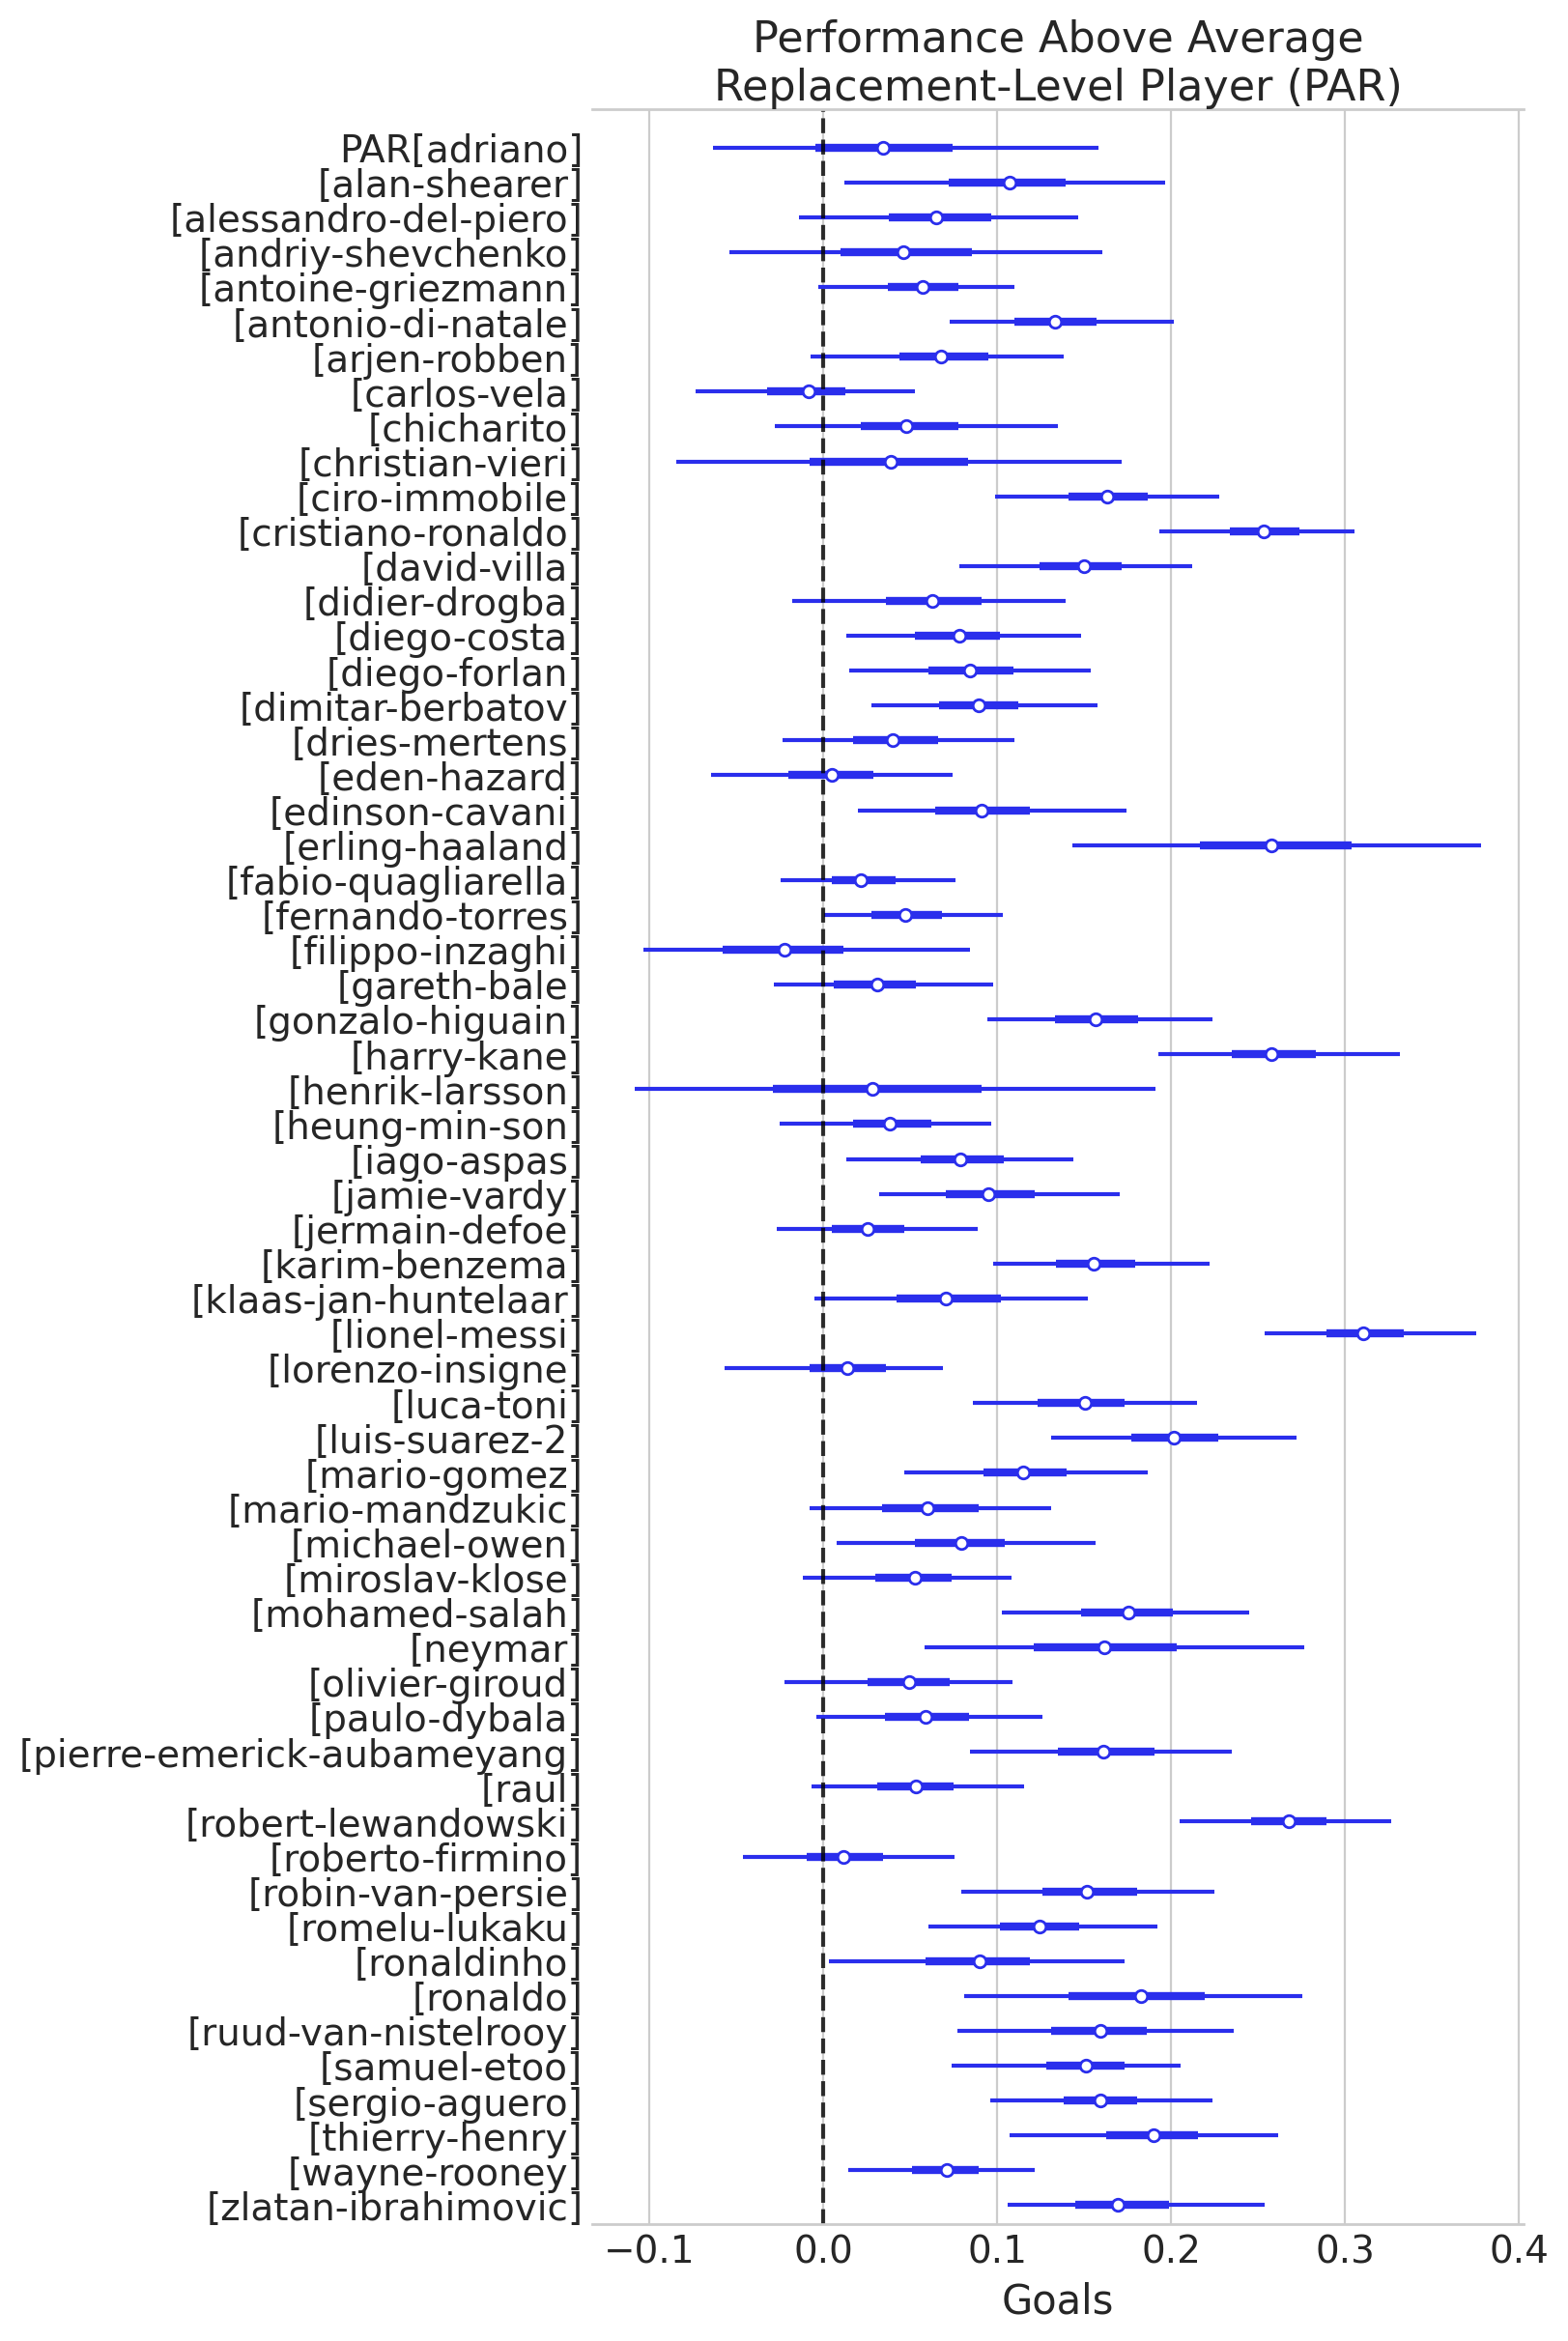

In [111]:
ax = az.plot_forest(PAR, combined=True, figsize=(8, 12))
ax[0].axvline(c="k", ls="--", alpha=0.8)
ax[0].set(
    title="Performance Above Average Replacement-Level Player (PAR)", xlabel="Goals"
);

### From equal teams

In [112]:
with SFM:
    # all teams are equal
    pm.set_data({"factor_data": np.zeros_like(factors_sdz)})

    counterfact_preds = pm.sample_posterior_predictive(
        idata,
        var_names=["y"],
        predictions=True,
        #compile_kwargs={"mode": "NUMBA"},
    )

Sampling: [gX, y]


Output()

In [113]:
counterfact_preds.predictions = counterfact_preds.predictions.assign_coords(
    mindex_coords_original
)

preds = counterfact_preds.predictions["y"].reset_index("obs_id")
rlp_perf = preds.where(preds["name_player"].isin(REPLACEMENT_LEVEL), drop=True)
elite_perf = preds.where(preds["name_player"].isin(ELITE_LEVEL), drop=True)

SAR = (
    elite_perf.groupby("name_player").mean("obs_id") - rlp_perf.mean("obs_id")
).rename("SAR")
diff = SAR - PAR

In [114]:
PLAYER_SUBSET = [
    "alan-shearer",
    "andriy-shevchenko",
    "cristiano-ronaldo",
    "eden-hazard",
    "erling-haaland",
    "falcao",
    "harry-kane",
    "lionel-messi",
    "ronaldinho",
    "ronaldo",
    "thierry-henry",
    "wayne-rooney",
    "robert-lewandowski"
]
SAR_plot = SAR.where(SAR["name_player"].isin(PLAYER_SUBSET), drop=True).rename("")
diff_plot = diff.where(diff["name_player"].isin(PLAYER_SUBSET), drop=True).rename("")

SAR_mean = SAR_plot.mean(("chain", "draw"))

# sort indices based on means in descending order
sorted_indices = np.argsort(-SAR_mean.to_numpy())

# reorder based on sorted indices
sorted_SAR_plot = SAR_plot.isel(name_player=sorted_indices)
sorted_SAR_plot["name_player"] = sorted_SAR_plot.name_player.str.replace(
    "-", " "
).str.title()
sorted_diff_plot = diff_plot.isel(name_player=sorted_indices)
sorted_diff_plot["name_player"] = sorted_diff_plot.name_player.str.replace(
    "-", " "
).str.title()

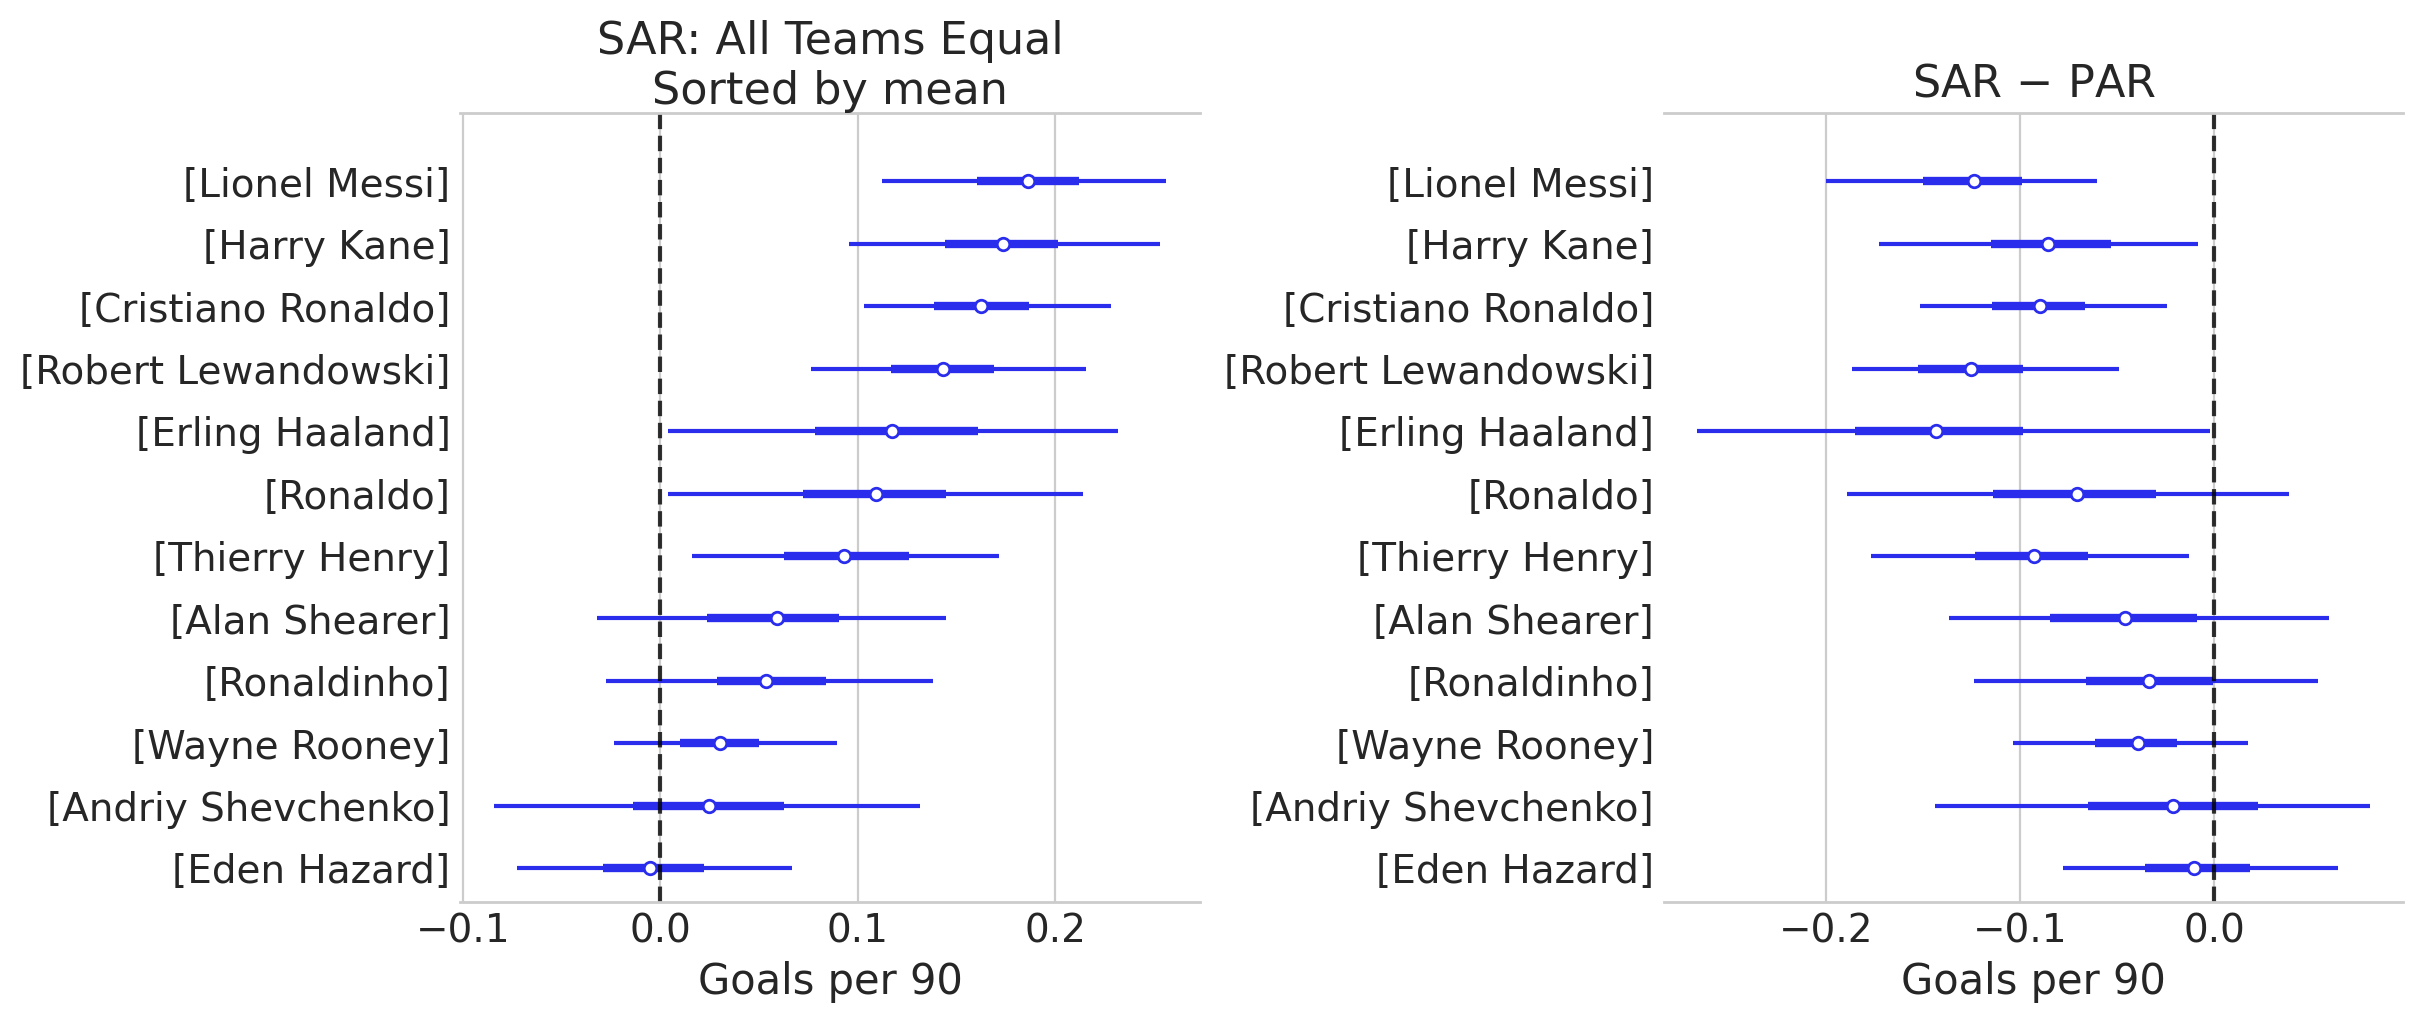

In [115]:
_, (left, right) = plt.subplots(1, 2)

az.plot_forest(sorted_SAR_plot, combined=True, ax=left)
az.plot_forest(sorted_diff_plot, combined=True, ax=right)

left.axvline(c="k", ls="--", alpha=0.8)
left.set(title="SAR: All Teams Equal\nSorted by mean", xlabel="Goals per 90")
right.axvline(c="k", ls="--", alpha=0.8)
right.set(title="SAR $-$ PAR", xlabel="Goals per 90");

In [ ]:
fig_left, left = plt.subplots(1, 1, figsize=(6,3.75))

az.plot_forest(sorted_SAR_plot, combined=True, ax=left)
left.axvline(c="k", ls="--", alpha=0.8)
left.set(title="", xlabel="Goals per 90")



fig_right, right = plt.subplots(1, 1, figsize=(6,3.75))

az.plot_forest(sorted_diff_plot, combined=True, ax=right)
right.axvline(c="k", ls="--", alpha=0.8)
right.set(title="", xlabel="Goals per 90");

In [ ]:
if 1==2:
    fig_right.savefig('../20_figures/SAR_right.png')
    fig_left.savefig('../20_figures/SAR_left.png')

## In-Sample Forecast Evaluation

### LOO-CV vs Competitor Models

1. *naive1*: player-specific $\alpha$ + g(factors) , where ``g(X)`` is a BART-type model
2. *naive2*: player-specific $\alpha$ + g(factors) , where ``g(X)`` is a linear model
4. *naive4*: player-specific $\alpha$

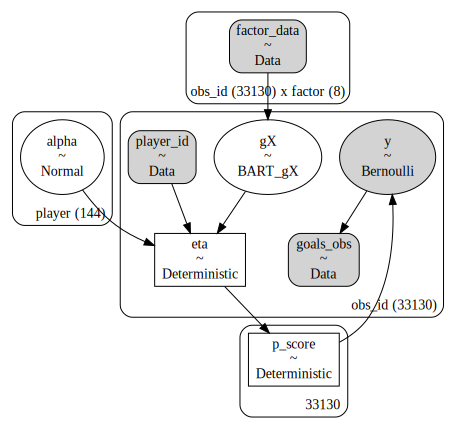

In [52]:
with pm.Model(coords=COORDS) as SFM_naive1:

    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    goals_obs = pm.Data(
        "goals_obs", complete_data["goal"].to_numpy(), dims="obs_id"
    )


    # ------------------------------------- Alpha ------------------------------------- #
    
    # --- Prior for "alpha"
    alpha = pm.Normal("alpha", sigma=1, dims="player")

    # ------------------------------------- BART for Team-Strength ------------------------------------- #
    
    gX = pmb.BART('gX', factor_data, complete_data["goal"].to_numpy() ,m=20,dims='obs_id')


    # ------------------------------------- Build the Conditional Mean ------------------------------------- #
    eta = pm.Deterministic(
        "eta", alpha[player_id] + gX, dims="obs_id"
    )

    # --- Probability of Scoring:
    p_score = pm.Deterministic('p_score', pm.math.sigmoid(eta))


    # --- Likelihood:
    y = pm.Bernoulli("y", p_score, observed=goals_obs,dims="obs_id")



pm.model_to_graphviz(SFM_naive1)

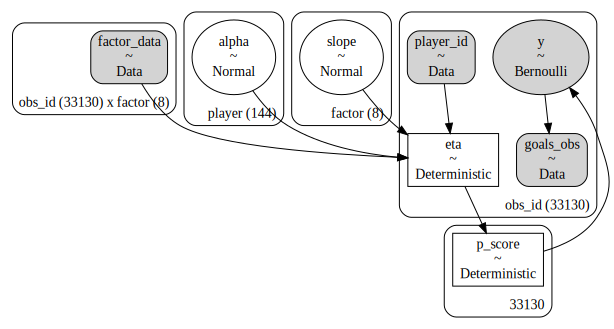

In [53]:
with pm.Model(coords=COORDS) as SFM_naive2:

    # Data containers
    factor_data = pm.Data(
        "factor_data", factors_sdz.to_numpy(), dims=("obs_id", "factor")
    )
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    goals_obs = pm.Data(
        "goals_obs", complete_data["goal"].to_numpy(), dims="obs_id"
    )


    # ------------------------------------- Alpha ------------------------------------- #
    
    # --- Prior for "alpha"
    alpha = pm.Normal("alpha", sigma=1, dims="player")

    # ------------------------------------- Factor Loadings ------------------------------------- #
    
    # --- Prior for Factor-Coefficients
    slope = pm.Normal("slope", sigma=2.5, dims="factor")


    # ------------------------------------- Build the Conditional Mean ------------------------------------- #
    eta = pm.Deterministic(
        "eta", alpha[player_id] + pm.math.dot(factor_data, slope), dims="obs_id"
    )

    # --- Probability of Scoring:
    p_score = pm.Deterministic('p_score', pm.math.sigmoid(eta))


    # --- Likelihood:
    y = pm.Bernoulli("y", p_score, observed=goals_obs,dims="obs_id")



pm.model_to_graphviz(SFM_naive2)

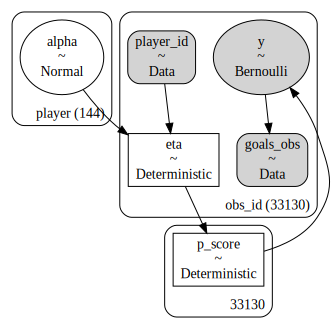

In [54]:
with pm.Model(coords=COORDS) as SFM_naive4:

    # Data containers
    player_id = pm.Data("player_id", player_idx, dims="obs_id")
    goals_obs = pm.Data(
        "goals_obs", complete_data["goal"].to_numpy(), dims="obs_id"
    )


    # ------------------------------------- Alpha ------------------------------------- #
    
    # --- Prior for "alpha"
    alpha = pm.Normal("alpha", sigma=1, dims="player")


    # ------------------------------------- Build the Conditional Mean ------------------------------------- #
    eta = pm.Deterministic(
        "eta", alpha[player_id], dims="obs_id"
    )

    # --- Probability of Scoring:
    p_score = pm.Deterministic('p_score', pm.math.sigmoid(eta))


    # --- Likelihood:
    y = pm.Bernoulli("y", p_score, observed=goals_obs,dims="obs_id")



pm.model_to_graphviz(SFM_naive4)

In [55]:
# ============================== Sample from the Posterior ============================== #
print('Sampling: naive1')
with SFM_naive1:
    idata_naive1 = pm.sample( target_accept=0.99, chains=1)
print('Sampling: naive2')
with SFM_naive2:
    idata_naive2 = pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=1)
print('Sampling: naive4')
with SFM_naive4:
    idata_naive4 = pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=1)

Sampling: naive1


Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [alpha]
>PGBART: [gX]


Output()

Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 497 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling: naive2


sample: 100%|█| 2000/2000 [01:55<00:00, 17.31it/s, 63 steps of size 7.09e-02. ac
Only one chain was sampled, this makes it impossible to run some convergence checks


Sampling: naive4


sample: 100%|█| 2000/2000 [00:38<00:00, 51.45it/s, 31 steps of size 1.33e-01. ac
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
# ============================== Compute Log-Likelihood of the Models ============================== #
if 1==2:
    with SFM:
        pm.compute_log_likelihood(idata)
    
    with SFM_naive1:
        pm.compute_log_likelihood(idata_naive1)
    
    with SFM_naive2:
        pm.compute_log_likelihood(idata_naive2)
    
    with SFM_naive4:
        pm.compute_log_likelihood(idata_naive4)
      

In [ ]:
# ============================== Model Comparison ============================== #
if 1==2:
    df_loo = az.compare({"SFM": idata, "Naive (1)": idata_naive1,"Naive (2)": idata_naive2, "Naive (3)": idata_naive4}) 
    df_loo

In [ ]:
if 1==2:
    fig, ax = plt.subplots(1, 1, figsize=(8,4))
    az.plot_compare(df_loo, insample_dev=False, title=False, ax=ax)
    plt.ylabel('')
    plt.xlabel('\nELPD', size=12)
    ax.tick_params(which='both',labelsize=10)
    plt.yticks(weight='bold')
    plt.show()

In [ ]:
if 1==2:
    fig.savefig('../20_figures/LOOCV.png')

### Coverage Statistic

In [56]:
# ==================== For Compatibility: Compute Posterior Predictives for the Benchmark Models ==================== #

with SFM_naive1:
    idata_naive1.extend(pm.sample_posterior_predictive(idata_naive1))
    idata_naive1.posterior_predictive = idata_naive1.posterior_predictive.rename({"y": "goals_scored"})

with SFM_naive2:
    idata_naive2.extend(pm.sample_posterior_predictive(idata_naive2))
    idata_naive2.posterior_predictive = idata_naive2.posterior_predictive.rename({"y": "goals_scored"})

with SFM_naive4:
    idata_naive4.extend(pm.sample_posterior_predictive(idata_naive4))
    idata_naive4.posterior_predictive = idata_naive4.posterior_predictive.rename({"y": "goals_scored"})



Sampling: [y]


Output()

Sampling: [y]


Output()

Sampling: [y]


Output()

In [64]:
# --------------------------------------- USER INTERACTION --------------------------------------- #

# --- Which model do you you want to evaluate? ['SFM','naive1','naive2','naive3']
take_mod = 'naive2'

# --------------------------------------- USER INTERACTION --------------------------------------- #

for take_mod in ['SFM','naive1','naive2','naive3']:

    if take_mod == 'SFM':
        df = idata.copy()
    elif take_mod == 'naive1':
        df = idata_naive1.copy()
    elif take_mod == 'naive2':
        df = idata_naive2.copy()
    elif take_mod == 'naive3':
        df = idata_naive4.copy()
    
    print(f'\n--------------------------- Selected Model: {take_mod} --------------------------- \n')
    y_hdi = az.hdi(df.posterior_predictive["goals_scored"])
    y_obs = df["observed_data"]["y"].to_numpy()
    is_within_hdi = (y_obs >= y_hdi.sel(hdi='lower')["goals_scored"].to_numpy()) & (y_obs <= y_hdi.sel(hdi='higher')["goals_scored"].to_numpy())
    print(f'Posterior 94% HDIs coverage: {np.round(is_within_hdi.mean()*100,2)}%')



--------------------------- Selected Model: SFM --------------------------- 

Posterior 94% HDIs coverage: 100.0%

--------------------------- Selected Model: naive1 --------------------------- 

Posterior 94% HDIs coverage: 99.99%

--------------------------- Selected Model: naive2 --------------------------- 

Posterior 94% HDIs coverage: 100.0%

--------------------------- Selected Model: naive3 --------------------------- 

Posterior 94% HDIs coverage: 100.0%


### Class-Frequencies

In [ ]:

# --------------------------------------- USER INTERACTION --------------------------------------- #

# --- Which model do you you want to evaluate? ['SFM','naive1','naive2','naive3']
take_mod = 'naive2'

# --------------------------------------- USER INTERACTION --------------------------------------- #

for take_mod in ['SFM','naive1','naive2','naive3']:

    if take_mod == 'SFM':
        df = idata.copy()
    elif take_mod == 'naive1':
        df = idata_naive1.copy()
    elif take_mod == 'naive2':
        df = idata_naive2.copy()
    elif take_mod == 'naive3':
        df = idata_naive4.copy()
    
    
    
    """
       Given the binary indicator G=0,1 -- which proportion of the observations ``y == G`` did the model predict correctly?
    """
    
    # --- Initialize the counter
    print(f'\n--------------------------- Selected Model: {take_mod} --------------------------- \n')
    all = 0
    all_g0 = 0
    for i in range(2):
        pct_per_class = np.mean(df.posterior_predictive['goals_scored'].where(df["observed_data"]["y"].to_numpy() == i) == i).to_numpy() * 100
        all += pct_per_class
        if i > 0:
            all_g0 += pct_per_class
        print(f'Accuracy --- # of Goals = {i}: {np.round(pct_per_class,2)}%')
    
    print(f'\nTotal Accuracy:         {np.round(all,2)}%')
    print(f'Accuracy (# Goals > 0): {np.round(all_g0,2)}%')


--------------------------- Selected Model: SFM --------------------------- 

Accuracy --- # of Goals = 0: 49.22%
Accuracy --- # of Goals = 1: 11.0%

Total Accuracy:         60.22%
Accuracy (# Goals > 0): 11.0%


### Classification Metrics

In [85]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

In [86]:
def PRC_AUC(y,yhat):

    # --- Get precision-recall pairs for different probability Thresholds
    vec_recall, vec_precision, _ = precision_recall_curve(y,yhat)

    # --- Get the Area Under The Curve
    prc_auc = auc(vec_recall,vec_precision)

    return prc_auc

In [121]:

# --------------------------------------- USER INTERACTION --------------------------------------- #

# --- Which model do you you want to evaluate? ['SFM','naive1','naive2','naive3']
take_mod = 'naive2'

# --- Which threshold shall be applied for setting probabilities to 0 or 1?
tt = 0.5

# --------------------------------------- USER INTERACTION --------------------------------------- #


print(f'\n====================================== Threshold for Discrimination: {tt} ====================================== \n')

for take_mod in ['SFM','naive1','naive2','naive3']:

    if take_mod == 'SFM':
        df = idata.copy()
    elif take_mod == 'naive1':
        df = idata_naive1.copy()
    elif take_mod == 'naive2':
        df = idata_naive2.copy()
    elif take_mod == 'naive3':
        df = idata_naive4.copy()


    # --- Extract the observed data:
    y = df["observed_data"]["y"].to_numpy()

    # --- Extract the predictions (probabilities):
    yhat = df.posterior['p_score'].to_numpy().mean(axis=1).flatten()
    
    # --- Convert predictions to binary indicator 
    yhat_bin = np.where(yhat > tt, 1.0, 0.0)
   
    
    # --- Initialize the counter
    print(f'\n--------------------------- Selected Model: {take_mod} --------------------------- \n')

    print(f'\nPrecision:   {np.round(precision_score(y,yhat_bin),2)}%')
    print(f'Recall:      {np.round(recall_score(y,yhat_bin),2)}%')
    print(f'F1-Score:    {np.round(f1_score(y,yhat_bin),2)}%')
    print(f'PRC-AUC:     {np.round(PRC_AUC(y,yhat_bin),2)}%')


====================================== Threshold for Discrimination: 0.5 ====================================== 


--------------------------- Selected Model: SFM --------------------------- 


Precision:   0.59%
Recall:      0.13%
F1-Score:    0.22%
PRC-AUC:     0.19%

--------------------------- Selected Model: naive1 --------------------------- 


Precision:   0.58%
Recall:      0.13%
F1-Score:    0.21%
PRC-AUC:     0.18%

--------------------------- Selected Model: naive2 --------------------------- 


Precision:   0.57%
Recall:      0.14%
F1-Score:    0.23%
PRC-AUC:     0.18%

--------------------------- Selected Model: naive3 --------------------------- 


Precision:   0.54%
Recall:      0.1%
F1-Score:    0.17%
PRC-AUC:     0.15%


## Versioning

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w